In [1]:
import xarray as xr
import dask.array
import numpy as np
import pandas as pd
import os
import scipy.io
import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import sys
sys.path.append('/home/Ruth.Moorman/OM4p25_JRA55-do_simulations')
### import required python functions
from om4_tools import *
from ssh_contours import *
## plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.cm as pcm
import cartopy.crs as ccrs
import cartopy.feature
import matplotlib.path as mpath
import matplotlib.ticker as mticker
import matplotlib.colors as col
import cmocean.cm as cm
from matplotlib import rc, rcParams
rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
import sys
sys.path.append('/home/Ruth.Moorman/')
from datetime import datetime
import nclcmaps
import cv2

In [2]:
rcParams["contour.negative_linestyle"] = 'solid'
rc('xtick', labelsize=20) 
rc('ytick', labelsize=20) 
rc('axes', labelsize=20)

In [3]:
def so_basics(ax,land_mask,geolon, geolat, lat_north = -29, grid = True):
    latslice = slice(-90,lat_north)
    ax.contour(geolon.sel(yh = latslice), geolat.sel(yh = latslice),land_mask.sel(yh = latslice),[0,1], colors = 'k', alpha = 1, transform=ccrs.PlateCarree())
    ax.set_extent([-180, 180, -90, lat_north], ccrs.PlateCarree())
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    if grid == True:
        gl = ax.gridlines(linewidth = 1, color = 'grey', linestyle = '--', alpha = 0.7)
        gl.ylocator = mticker.FixedLocator([-90,-80,-70, -60, -50, -40, -30])

In [4]:
#static
expdir = '/archive/Ruth.Moorman/OM4p25_IAF_BLING_CFC_csf_JRA55do1-3_r4r/'
static_25 = xr.open_dataset(expdir+'/cycle1/ocean_static/20170101.ocean_static.nc')
bathy_25 = static_25.deptho.load()
land_mask_25 = static_25.wet_u.load()
geolon_25 = static_25.geolon_u.load()
geolat_25 = static_25.geolat_u.load()
#
static_5 = xr.open_mfdataset('/archive/oar.gfdl.ogrp-account/CMIP6/OMIP/xanadu_mom6_20181101/OM4p5_IAF_BLING_CFC_abio_csf_mle200_JRA55do1-3_r4r_cycle1/gfdl.ncrc4-intel16f2-prod/pp/ocean_monthly/ocean_monthly.static.nc')
bathy_5 = static_5.deptho.load()
land_mask_5 = static_5.wet_u.load()
geolon_5 = static_5.geolon_u.load()
geolat_5 = static_5.geolat_u.load()
#
exp_dir = '/archive/oar.gfdl.ogrp-account/CMIP6/OMIP/xanadu_mom6_20181101/OM4p125_IAF_csf_JRA55do1-3_r5_cycle2/gfdl.ncrc4-intel16f2-prod/pp'
static_125 = xr.open_dataset(exp_dir+'/ocean_daily/ocean_daily.static.nc')
bathy_125 = static_125.deptho.load()
land_mask_125 = static_125.wet_u.load()
geolon_125 = static_125.geolon_u.load()
geolat_125 = static_125.geolat_u.load()

In [5]:
geolon_25 = geolon_25.sel(yh = slice(-90,-29))
geolat_25 = geolat_25.sel(yh = slice(-90,-29))
geolon_5 = geolon_5.sel(yh = slice(-90,-29))
geolat_5 = geolat_5.sel(yh = slice(-90,-29))
geolon_125 = geolon_125.sel(yh = slice(-90,-29))
geolat_125 = geolat_125.sel(yh = slice(-90,-29))

In [6]:
land_mask_25 = land_mask_25.sel(yh = slice(-90,-29))
land_mask_5 = land_mask_5.sel(yh = slice(-90,-29))
land_mask_125 = land_mask_125.sel(yh = slice(-90,-29))

p25 we can use the `umo_2d` variable.

## previous computation, skip ahead

In [21]:
p25_umo_2d_C1 = get_iaf_variable(expdir, 1, 'ocean_annual', 'umo_2d')
p25_umo_2d_C2 = get_iaf_variable(expdir, 2, 'ocean_annual', 'umo_2d')
p25_umo_2d_C3 = get_iaf_variable(expdir, 3, 'ocean_annual', 'umo_2d')

In [22]:
p25_umo_2d_C1_mean = p25_umo_2d_C1.sel(time = slice('1993','2017')).mean(dim = 'time').load()
p25_umo_2d_C2_mean = p25_umo_2d_C2.sel(time = slice('1993','2017')).mean(dim = 'time').load()
p25_umo_2d_C3_mean = p25_umo_2d_C3.sel(time = slice('1993','2017')).mean(dim = 'time').load()

for the rest, we need to load and vertically integrate `umo`

In [64]:
p5_umo_C1 = xr.open_mfdataset('/archive/oar.gfdl.ogrp-account/CMIP6/OMIP/xanadu_mom6_20181101/OM4p5_IAF_BLING_CFC_abio_csf_mle200_JRA55do1-3_r4r_cycle1/gfdl.ncrc4-intel16f2-prod/pp/ocean_annual_z/ts/annual/20yr/ocean_annual_z.*.umo.nc')
p5_umo_C2 = xr.open_mfdataset('/archive/oar.gfdl.ogrp-account/CMIP6/OMIP/xanadu_mom6_20181101/OM4p5_IAF_BLING_CFC_abio_csf_mle200_JRA55do1-3_r4r_cycle2/gfdl.ncrc4-intel16f2-prod/pp/ocean_annual_z/ts/annual/20yr/ocean_annual_z.*.umo.nc')
p5_umo_C3 = xr.open_mfdataset('/archive/oar.gfdl.ogrp-account/CMIP6/OMIP/xanadu_mom6_20181101/OM4p5_IAF_BLING_CFC_abio_csf_mle200_JRA55do1-3_r4r_cycle3/gfdl.ncrc4-intel16f2-prod/pp/ocean_annual_z/ts/annual/20yr/ocean_annual_z.*.umo.nc')
p5_umo_C4 = xr.open_mfdataset('/archive/oar.gfdl.ogrp-account/CMIP6/OMIP/xanadu_mom6_20181101/OM4p5_IAF_BLING_CFC_abio_csf_mle200_JRA55do1-3_r4r_cycle4/gfdl.ncrc4-intel16f2-prod/pp/ocean_annual_z/ts/annual/20yr/ocean_annual_z.*.umo.nc')
p5_umo_C1 = p5_umo_C1.umo
p5_umo_C2 = p5_umo_C2.umo
p5_umo_C3 = p5_umo_C3.umo
p5_umo_C4 = p5_umo_C4.umo
p5_umo_2d_C1_mean = p5_umo_C1.sum(dim = 'z_l').sel(time = slice('1993','2017')).mean(dim = 'time').load()
p5_umo_2d_C2_mean = p5_umo_C2.sum(dim = 'z_l').sel(time = slice('1993','2017')).mean(dim = 'time').load()
p5_umo_2d_C3_mean = p5_umo_C3.sum(dim = 'z_l').sel(time = slice('1993','2017')).mean(dim = 'time').load()
p5_umo_2d_C4_mean = p5_umo_C4.sum(dim = 'z_l').sel(time = slice('1993','2017')).mean(dim = 'time').load()

In [20]:
p125_umo_C1 = xr.open_mfdataset('/archive/oar.gfdl.ogrp-account/CMIP6/OMIP/xanadu_mom6_20181101/OM4p125_IAF_csf_JRA55do1-3_r5_cycle1/gfdl.ncrc4-intel16f2-prod/pp/ocean_annual_z/ts/annual/20yr/ocean_annual_z.*.umo.nc')
p125_umo_C2 = xr.open_mfdataset('/archive/oar.gfdl.ogrp-account/CMIP6/OMIP/xanadu_mom6_20181101/OM4p125_IAF_csf_JRA55do1-3_r5_cycle2/gfdl.ncrc4-intel16f2-prod/pp/ocean_annual_z/ts/annual/20yr/ocean_annual_z.*.umo.nc')
p125_umo_C3 = xr.open_mfdataset('/archive/oar.gfdl.ogrp-account/CMIP6/OMIP/xanadu_mom6_20181101/OM4p125_IAF_csf_JRA55do1-3_r5_cycle3/gfdl.ncrc4-intel16f2-prod/pp/ocean_annual_z/ts/annual/20yr/ocean_annual_z.*.umo.nc')
p125_umo_C1 = p125_umo_C1.umo
p125_umo_C2 = p125_umo_C2.umo
p125_umo_C3 = p125_umo_C3.umo
p125_umo_2d_C1_mean = p125_umo_C1.sum(dim = 'z_l').sel(time = slice('1993','2017')).mean(dim = 'time').load()
p125_umo_2d_C2_mean = p125_umo_C2.sum(dim = 'z_l').sel(time = slice('1993','2017')).mean(dim = 'time').load()
p125_umo_2d_C3_mean = p125_umo_C3.sum(dim = 'z_l').sel(time = slice('1993','2017')).mean(dim = 'time').load()

In [67]:
p125_umo_mle_C1 = xr.open_mfdataset('/archive/Raphael.Dussin/xanadu_esm4_20190304_mom6_2019.12.16/OM4p125_JRA55do1.4_mle3d_cycle1/gfdl.ncrc4-intel16-prod/pp/ocean_annual_z/ts/annual/20yr/ocean_annual_z.*.umo.nc')
p125_umo_mle_C2 = xr.open_mfdataset('/archive/Raphael.Dussin/xanadu_esm4_20190304_mom6_2019.12.16/OM4p125_JRA55do1.4_mle3d_cycle2/gfdl.ncrc4-intel16-prod/pp/ocean_annual_z/ts/annual/20yr/ocean_annual_z.*.umo.nc')
p125_umo_mle_C3 = xr.open_mfdataset('/archive/Raphael.Dussin/xanadu_esm4_20190304_mom6_2019.12.16/OM4p125_JRA55do1.4_mle3d_cycle3/gfdl.ncrc4-intel16-prod/pp/ocean_annual_z/ts/annual/20yr/ocean_annual_z.*.umo.nc')
p125_umo_mle_C1 = p125_umo_mle_C1.umo
p125_umo_mle_C2 = p125_umo_mle_C2.umo
p125_umo_mle_C3 = p125_umo_mle_C3.umo
p125_umo_2d_mle_C1_mean = p125_umo_mle_C1.sum(dim = 'z_l').sel(time = slice('1993','2017')).mean(dim = 'time').load()
p125_umo_2d_mle_C2_mean = p125_umo_mle_C2.sum(dim = 'z_l').sel(time = slice('1993','2017')).mean(dim = 'time').load()
p125_umo_2d_mle_C3_mean = p125_umo_mle_C3.sum(dim = 'z_l').sel(time = slice('1993','2017')).mean(dim = 'time').load()

In [15]:
def OM4_ACCS_psig_contour(umo_2D,lat_north = -29):
    ρ = 1036 # kg/m^3
    psi = -umo_2D.cumsum('yh')/(1e6*ρ) # divide by 1e6 to convert m^3/s
    psi_acc = np.nanmin(psi.sel(xq = slice(-69, -67), yh = slice(-80, -55)))
    print('Max value of streamfunction south of 55S and within 69W-67W (ACC transport) = ', -psi_acc, 'Sv')
    psi_g = psi-psi_acc
    psi_g = psi_g.rename('Barotropic Stream function')
    psi_g.attrs['long_name'] = 'Barotropic Stream function'
    psi_g.attrs['units'] = 'Sv'
    
    adjust = 0
    for k in range(10):
        
        contour = -psi_acc-(adjust * 0.1)
        temp = psi_g.where(psi_g>=contour) * 0 + 1
        temp_mask = psi_g.copy().fillna(1)
        xh = temp_mask.xq
        yh = temp_mask.yh
        temp_mask = temp_mask.where(temp_mask >= contour) * 0 + 1
        temp_mask = temp_mask.fillna(0)
        temp_mask = temp_mask.values # extract numpy file
        # # this spreads the isobath contour so all points are connected adjacently (not just 
        # # diagonally):

        kernel = np.ones((3,3),np.uint8)
        contour_mask0 = cv2.dilate(temp_mask,kernel,iterations=1) - temp_mask
        # start at western edge of domain, at y point closest to correct depth contour:
        contour_mask = np.zeros_like(temp_mask) 
        contour_lat_index_start = np.where(contour_mask0[:,0]>0)[0][-1]
        contour_mask[contour_lat_index_start,0] = 1
        # loop through to find adjacent point closest to contour depth (not inc previous point):
        last_index_i = np.array([0])
        last_index_j = contour_lat_index_start
        count = np.array([0])


        while last_index_i<(len(xh)-1): # 1440 is xh dimension length
            # first time don't go backwards:
            if last_index_i == 0:
                points_to_compare = np.array([contour_mask0[last_index_j,last_index_i+1],
                    0,
                    contour_mask0[last_index_j+1,last_index_i],
                    contour_mask0[last_index_j-1,last_index_i]])
            else:
                points_to_compare = np.array([contour_mask0[last_index_j,last_index_i+1],
                    contour_mask0[last_index_j,last_index_i-1],
                    contour_mask0[last_index_j+1,last_index_i],
                    contour_mask0[last_index_j-1,last_index_i]])
            new_loc = np.where(points_to_compare==1)[0]
            # this gives each point along contour a unique index number:
            if len(new_loc)==0:
                contour_mask0[last_index_j,last_index_i] = 0
                count = count - 1
                last_index_i = np.where(contour_mask==count+1)[1]
                last_index_j = np.where(contour_mask==count+1)[0]
                if len(last_index_i)>1:
                    last_index_i = last_index_i[0]
                    last_index_j = last_index_j[0]
                else:
                    continue
            elif len(new_loc)>0:
                if new_loc[0] == 0:
                    new_index_i = last_index_i+1
                    new_index_j = last_index_j
                elif new_loc[0] == 1:
                    new_index_i = last_index_i-1
                    new_index_j = last_index_j
                elif new_loc[0] == 2:
                    new_index_i = last_index_i
                    new_index_j = last_index_j+1            
                elif new_loc[0] == 3:
                    new_index_i = last_index_i
                    new_index_j = last_index_j-1

                contour_mask[new_index_j,new_index_i] = count + 2
                contour_mask0[last_index_j,last_index_i] = 2
                last_index_j = new_index_j
                last_index_i = new_index_i
                count += 1
                if len(np.array([last_index_i])) >1:
                    last_index_i = last_index_i[0]
                    last_index_j = last_index_j[0]
        if np.sum(contour_mask, axis = 0).min() == 1:
            # sometimes the contour fitting algorithm falls onto the land mask edge and stays there, erroneously resulting in a circumpolar continuous contour. Add the constraint that the final index does not coincide with land (seems to be enough).
#             print('adjusted:',adjust)
            break
        else:
            adjust += 1 
    # # this is the sequentially numbered isobath, it provides an along isobath index
    contour_mask_numbered = contour_mask
    # sometimes there's a discontinuoity at 0
    if last_index_j > contour_lat_index_start:
        a = 0
        for m in np.arange(last_index_j,contour_lat_index_start-1, -1):
            contour_mask_numbered[m,-1] = contour_mask_numbered[last_index_j,-1] +a
            a += 1
    elif last_index_j < contour_lat_index_start:
        a = 0
        for m in np.arange(last_index_j, contour_lat_index_start+1, 1):
            contour_mask_numbered[m,-1] = contour_mask_numbered[last_index_j,-1] +a
            a += 1
    # fill in points to north of contour:
    contour_masked_above = np.copy(contour_mask_numbered)
    contour_masked_above[-1,0] = -100

    # from top left:
    for ii in range(len(xh)-1):
        for jj in range(len(yh))[::-1][:-1]:
            if contour_masked_above[jj,ii] == -100:
                if contour_masked_above[jj-1,ii] == 0:
                    contour_masked_above[jj-1,ii] = -100
                if contour_masked_above[jj,ii+1] == 0:
                    contour_masked_above[jj,ii+1] = -100
                if contour_masked_above[jj-1,ii+1] == 0:
                    contour_masked_above[jj-1,ii+1] = -100
    # from top right:
    for ii in range(len(xh))[::-1][:-1]:
        for jj in range(len(yh))[::-1][:-1]:
            if contour_masked_above[jj,ii] == -100:
                if contour_masked_above[jj-1,ii] == 0:
                    contour_masked_above[jj-1,ii] = -100
                if contour_masked_above[jj,ii-1] == 0:
                    contour_masked_above[jj,ii-1] = -100
                if contour_masked_above[jj-1,ii-1] == 0:
                    contour_masked_above[jj-1,ii-1] = -100
    # from bottom right:
    for ii in range(len(xh))[::-1][:-1]:
        for jj in range(len(yh)-1):
            if contour_masked_above[jj,ii] == -100:
                if contour_masked_above[jj+1,ii] == 0:
                    contour_masked_above[jj+1,ii] = -100
                if contour_masked_above[jj,ii-1] == 0:
                    contour_masked_above[jj,ii-1] = -100
                if contour_masked_above[jj+1,ii-1] == 0:
                    contour_masked_above[jj+1,ii-1] = -100
    # from bottom left:
    for ii in range(len(xh)-1):
        for jj in range(len(yh)-1):
            if contour_masked_above[jj,ii] == -100:
                if contour_masked_above[jj+1,ii] == 0:
                    contour_masked_above[jj+1,ii] = -100
                if contour_masked_above[jj,ii+1] == 0:
                    contour_masked_above[jj,ii+1] = -100
                if contour_masked_above[jj+1,ii+1] == 0:
                    contour_masked_above[jj+1,ii+1] = -100
    contour_mask_numbered = xr.DataArray(contour_mask_numbered, coords = [yh, xh], dims = ['yh', 'xq'])
    contour_masked_south = xr.DataArray(contour_masked_above, coords = [yh, xh], dims = ['yh', 'xq'])
    contour_masked_south = contour_masked_south.where(contour_masked_south >= 0) * 0 + 1 
    
    return contour_mask_numbered, contour_masked_south,psi_g, -psi_acc, contour

In [34]:
# p25 - cycle1
contour_mask_numbered, contour_masked_south,psi_g,psi_acc, contour = OM4_ACCS_psig_contour(p25_umo_2d_C1_mean)
contour_masked_south.attrs['long_name'] = 'Mask for the region south of the southernmost cicumpolar continuous barotropic streamfunction contour'
contour_masked_south.attrs['time_avg_info'] = '1993-2017 mean umo_2D used'
contour_mask_numbered.attrs['long_name'] = 'Numbered southernmost cicumpolar continuous barotropic streamfunction contour'
contour_mask_numbered.attrs['time_avg_info'] = '1993-2017 mean umo_2D used'
contour_mask_numbered.attrs['contour_psig_value'] = str(contour)[:6]
contour_masked_south.attrs['contour_psig_value'] = str(contour)[:6]
psi_g.attrs['time_avg_info']  = '1993-2017 satellite era mean ssh'
psi_g.attrs['long_name']  = 'Barotropic streamfunction (positive is clockwise flow)'
ds = xr.Dataset({'psig':psi_g,'contour_mask_numbered':contour_mask_numbered, 'contour_masked_south':contour_masked_south})
ds.coords['geolon_u'] = geolon_25
ds.coords['geolat_u'] = geolat_25
ds.to_netcdf('/work/Ruth.Moorman/masks_and_contours/OM4p25_IAF_BLING_CFC_csf_JRA55do1-3_r4r/cycle1_1993-2017_mean_SUC-psig.nc')

Max value of streamfunction south of 55S and within 69W-67W (ACC transport) =  144.44508 Sv


In [35]:
# p25 - cycle2
contour_mask_numbered, contour_masked_south,psi_g,psi_acc, contour = OM4_ACCS_psig_contour(p25_umo_2d_C2_mean)
contour_masked_south.attrs['long_name'] = 'Mask for the region south of the southernmost cicumpolar continuous barotropic streamfunction contour'
contour_masked_south.attrs['time_avg_info'] = '1993-2017 mean umo_2D used'
contour_mask_numbered.attrs['long_name'] = 'Numbered southernmost cicumpolar continuous barotropic streamfunction contour'
contour_mask_numbered.attrs['time_avg_info'] = '1993-2017 mean umo_2D used'
contour_mask_numbered.attrs['contour_psig_value'] = str(contour)[:6]
contour_masked_south.attrs['contour_psig_value'] = str(contour)[:6]
psi_g.attrs['time_avg_info']  = '1993-2017 satellite era mean ssh'
psi_g.attrs['long_name']  = 'Barotropic streamfunction (positive is clockwise flow)'
ds = xr.Dataset({'psig':psi_g,'contour_mask_numbered':contour_mask_numbered, 'contour_masked_south':contour_masked_south})
ds.coords['geolon_u'] = geolon_25
ds.coords['geolat_u'] = geolat_25
ds.to_netcdf('/work/Ruth.Moorman/masks_and_contours/OM4p25_IAF_BLING_CFC_csf_JRA55do1-3_r4r/cycle2_1993-2017_mean_SUC-psig.nc')

Max value of streamfunction south of 55S and within 69W-67W (ACC transport) =  151.41081 Sv


In [36]:
# p25 - cycle3
contour_mask_numbered, contour_masked_south,psi_g,psi_acc, contour = OM4_ACCS_psig_contour(p25_umo_2d_C3_mean)
contour_masked_south.attrs['long_name'] = 'Mask for the region south of the southernmost cicumpolar continuous barotropic streamfunction contour'
contour_masked_south.attrs['time_avg_info'] = '1993-2017 mean umo_2D used'
contour_mask_numbered.attrs['long_name'] = 'Numbered southernmost cicumpolar continuous barotropic streamfunction contour'
contour_mask_numbered.attrs['time_avg_info'] = '1993-2017 mean umo_2D used'
contour_mask_numbered.attrs['contour_psig_value'] = str(contour)[:6]
contour_masked_south.attrs['contour_psig_value'] = str(contour)[:6]
psi_g.attrs['time_avg_info']  = '1993-2017 satellite era mean ssh'
psi_g.attrs['long_name']  = 'Barotropic streamfunction (positive is clockwise flow)'
ds = xr.Dataset({'psig':psi_g,'contour_mask_numbered':contour_mask_numbered, 'contour_masked_south':contour_masked_south})
ds.coords['geolon'] = geolon_25
ds.coords['geolat'] = geolat_25
ds.to_netcdf('/work/Ruth.Moorman/masks_and_contours/OM4p25_IAF_BLING_CFC_csf_JRA55do1-3_r4r/cycle3_1993-2017_mean_SUC-psig.nc')

Max value of streamfunction south of 55S and within 69W-67W (ACC transport) =  151.10712 Sv


In [41]:
# p5 - cycle1
contour_mask_numbered, contour_masked_south,psi_g,psi_acc, contour = OM4_ACCS_psig_contour(p5_umo_2d_C1_mean)
contour_masked_south.attrs['long_name'] = 'Mask for the region south of the southernmost cicumpolar continuous barotropic streamfunction contour'
contour_masked_south.attrs['time_avg_info'] = '1993-2017 mean umo_2D used'
contour_mask_numbered.attrs['long_name'] = 'Numbered southernmost cicumpolar continuous barotropic streamfunction contour'
contour_mask_numbered.attrs['time_avg_info'] = '1993-2017 mean umo_2D used'
contour_mask_numbered.attrs['contour_psig_value'] = str(contour)[:6]
contour_masked_south.attrs['contour_psig_value'] = str(contour)[:6]
psi_g.attrs['time_avg_info']  = '1993-2017 satellite era mean ssh'
psi_g.attrs['long_name']  = 'Barotropic streamfunction (positive is clockwise flow)'
ds = xr.Dataset({'psig':psi_g,'contour_mask_numbered':contour_mask_numbered, 'contour_masked_south':contour_masked_south})
ds.coords['geolon_u'] = geolon_5
ds.coords['geolat_u'] = geolat_5
ds.to_netcdf('/work/Ruth.Moorman/masks_and_contours/OM4p5_IAF_BLING_CFC_abio_csf_mle200_JRA55do1-3_r4r/cycle1_1993-2017_mean_SUC-psig.nc')

Max value of streamfunction south of 55S and within 69W-67W (ACC transport) =  165.0654 Sv


In [44]:
# p5 - cycle2
contour_mask_numbered, contour_masked_south,psi_g,psi_acc, contour = OM4_ACCS_psig_contour(p5_umo_2d_C2_mean)
contour_masked_south.attrs['long_name'] = 'Mask for the region south of the southernmost cicumpolar continuous barotropic streamfunction contour'
contour_masked_south.attrs['time_avg_info'] = '1993-2017 mean umo_2D used'
contour_mask_numbered.attrs['long_name'] = 'Numbered southernmost cicumpolar continuous barotropic streamfunction contour'
contour_mask_numbered.attrs['time_avg_info'] = '1993-2017 mean umo_2D used'
contour_mask_numbered.attrs['contour_psig_value'] = str(contour)[:6]
contour_masked_south.attrs['contour_psig_value'] = str(contour)[:6]
psi_g.attrs['time_avg_info']  = '1993-2017 satellite era mean ssh'
psi_g.attrs['long_name']  = 'Barotropic streamfunction (positive is clockwise flow)'
ds = xr.Dataset({'psig':psi_g,'contour_mask_numbered':contour_mask_numbered, 'contour_masked_south':contour_masked_south})
ds.coords['geolon_u'] = geolon_5
ds.coords['geolat_u'] = geolat_5
ds.to_netcdf('/work/Ruth.Moorman/masks_and_contours/OM4p5_IAF_BLING_CFC_abio_csf_mle200_JRA55do1-3_r4r/cycle2_1993-2017_mean_SUC-psig.nc')

Max value of streamfunction south of 55S and within 69W-67W (ACC transport) =  162.33496 Sv


In [45]:
# p5 - cycle3
contour_mask_numbered, contour_masked_south,psi_g,psi_acc, contour = OM4_ACCS_psig_contour(p5_umo_2d_C3_mean)
contour_masked_south.attrs['long_name'] = 'Mask for the region south of the southernmost cicumpolar continuous barotropic streamfunction contour'
contour_masked_south.attrs['time_avg_info'] = '1993-2017 mean umo_2D used'
contour_mask_numbered.attrs['long_name'] = 'Numbered southernmost cicumpolar continuous barotropic streamfunction contour'
contour_mask_numbered.attrs['time_avg_info'] = '1993-2017 mean umo_2D used'
contour_mask_numbered.attrs['contour_psig_value'] = str(contour)[:6]
contour_masked_south.attrs['contour_psig_value'] = str(contour)[:6]
psi_g.attrs['time_avg_info']  = '1993-2017 satellite era mean ssh'
psi_g.attrs['long_name']  = 'Barotropic streamfunction (positive is clockwise flow)'
ds = xr.Dataset({'psig':psi_g,'contour_mask_numbered':contour_mask_numbered, 'contour_masked_south':contour_masked_south})
ds.coords['geolon_u'] = geolon_5
ds.coords['geolat_u'] = geolat_5
ds.to_netcdf('/work/Ruth.Moorman/masks_and_contours/OM4p5_IAF_BLING_CFC_abio_csf_mle200_JRA55do1-3_r4r/cycle3_1993-2017_mean_SUC-psig.nc')

Max value of streamfunction south of 55S and within 69W-67W (ACC transport) =  159.41905 Sv


In [65]:
# p5 - cycle4
contour_mask_numbered, contour_masked_south,psi_g,psi_acc, contour = OM4_ACCS_psig_contour(p5_umo_2d_C4_mean)
contour_masked_south.attrs['long_name'] = 'Mask for the region south of the southernmost cicumpolar continuous barotropic streamfunction contour'
contour_masked_south.attrs['time_avg_info'] = '1993-2017 mean umo_2D used'
contour_mask_numbered.attrs['long_name'] = 'Numbered southernmost cicumpolar continuous barotropic streamfunction contour'
contour_mask_numbered.attrs['time_avg_info'] = '1993-2017 mean umo_2D used'
contour_mask_numbered.attrs['contour_psig_value'] = str(contour)[:6]
contour_masked_south.attrs['contour_psig_value'] = str(contour)[:6]
psi_g.attrs['time_avg_info']  = '1993-2017 satellite era mean ssh'
psi_g.attrs['long_name']  = 'Barotropic streamfunction (positive is clockwise flow)'
ds = xr.Dataset({'psig':psi_g,'contour_mask_numbered':contour_mask_numbered, 'contour_masked_south':contour_masked_south})
ds.coords['geolon_u'] = geolon_5
ds.coords['geolat_u'] = geolat_5
ds.to_netcdf('/work/Ruth.Moorman/masks_and_contours/OM4p5_IAF_BLING_CFC_abio_csf_mle200_JRA55do1-3_r4r/cycle4_1993-2017_mean_SUC-psig.nc')

Max value of streamfunction south of 55S and within 69W-67W (ACC transport) =  162.22388 Sv


In [68]:
# p125mle - cycle1
contour_mask_numbered, contour_masked_south,psi_g,psi_acc, contour = OM4_ACCS_psig_contour(p125_umo_2d_mle_C1_mean)
contour_masked_south.attrs['long_name'] = 'Mask for the region south of the southernmost cicumpolar continuous barotropic streamfunction contour'
contour_masked_south.attrs['time_avg_info'] = '1993-2017 mean umo_2D used'
contour_mask_numbered.attrs['long_name'] = 'Numbered southernmost cicumpolar continuous barotropic streamfunction contour'
contour_mask_numbered.attrs['time_avg_info'] = '1993-2017 mean umo_2D used'
contour_mask_numbered.attrs['contour_psig_value'] = str(contour)[:6]
contour_masked_south.attrs['contour_psig_value'] = str(contour)[:6]
psi_g.attrs['time_avg_info']  = '1993-2017 satellite era mean ssh'
psi_g.attrs['long_name']  = 'Barotropic streamfunction (positive is clockwise flow)'
ds = xr.Dataset({'psig':psi_g,'contour_mask_numbered':contour_mask_numbered, 'contour_masked_south':contour_masked_south})
ds.coords['geolon_u'] = geolon_125
ds.coords['geolat_u'] = geolat_125
ds.to_netcdf('/work/Ruth.Moorman/masks_and_contours/OM4p125_JRA55do1.4_mle3d/cycle1_1993-2017_mean_SUC-psig.nc')

Max value of streamfunction south of 55S and within 69W-67W (ACC transport) =  140.15535 Sv


In [70]:
# p125mle - cycle2
contour_mask_numbered, contour_masked_south,psi_g,psi_acc, contour = OM4_ACCS_psig_contour(p125_umo_2d_mle_C2_mean)
contour_masked_south.attrs['long_name'] = 'Mask for the region south of the southernmost cicumpolar continuous barotropic streamfunction contour'
contour_masked_south.attrs['time_avg_info'] = '1993-2017 mean umo_2D used'
contour_mask_numbered.attrs['long_name'] = 'Numbered southernmost cicumpolar continuous barotropic streamfunction contour'
contour_mask_numbered.attrs['time_avg_info'] = '1993-2017 mean umo_2D used'
contour_mask_numbered.attrs['contour_psig_value'] = str(contour)[:6]
contour_masked_south.attrs['contour_psig_value'] = str(contour)[:6]
psi_g.attrs['time_avg_info']  = '1993-2017 satellite era mean ssh'
psi_g.attrs['long_name']  = 'Barotropic streamfunction (positive is clockwise flow)'
ds = xr.Dataset({'psig':psi_g,'contour_mask_numbered':contour_mask_numbered, 'contour_masked_south':contour_masked_south})
ds.coords['geolon_u'] = geolon_125
ds.coords['geolat_u'] = geolat_125
ds.to_netcdf('/work/Ruth.Moorman/masks_and_contours/OM4p125_JRA55do1.4_mle3d/cycle2_1993-2017_mean_SUC-psig.nc')

Max value of streamfunction south of 55S and within 69W-67W (ACC transport) =  142.13887 Sv


In [71]:
# p125mle - cycle3
contour_mask_numbered, contour_masked_south,psi_g,psi_acc, contour = OM4_ACCS_psig_contour(p125_umo_2d_mle_C3_mean)
contour_masked_south.attrs['long_name'] = 'Mask for the region south of the southernmost cicumpolar continuous barotropic streamfunction contour'
contour_masked_south.attrs['time_avg_info'] = '1993-2017 mean umo_2D used'
contour_mask_numbered.attrs['long_name'] = 'Numbered southernmost cicumpolar continuous barotropic streamfunction contour'
contour_mask_numbered.attrs['time_avg_info'] = '1993-2017 mean umo_2D used'
contour_mask_numbered.attrs['contour_psig_value'] = str(contour)[:6]
contour_masked_south.attrs['contour_psig_value'] = str(contour)[:6]
psi_g.attrs['time_avg_info']  = '1993-2017 satellite era mean ssh'
psi_g.attrs['long_name']  = 'Barotropic streamfunction (positive is clockwise flow)'
ds = xr.Dataset({'psig':psi_g,'contour_mask_numbered':contour_mask_numbered, 'contour_masked_south':contour_masked_south})
ds.coords['geolon_u'] = geolon_125
ds.coords['geolat_u'] = geolat_125
ds.to_netcdf('/work/Ruth.Moorman/masks_and_contours/OM4p125_JRA55do1.4_mle3d/cycle3_1993-2017_mean_SUC-psig.nc')

Max value of streamfunction south of 55S and within 69W-67W (ACC transport) =  142.58482 Sv


In [73]:
# p125 - cycle1
contour_mask_numbered, contour_masked_south,psi_g,psi_acc, contour = OM4_ACCS_psig_contour(p125_umo_2d_C1_mean)
contour_masked_south.attrs['long_name'] = 'Mask for the region south of the southernmost cicumpolar continuous barotropic streamfunction contour'
contour_masked_south.attrs['time_avg_info'] = '1993-2017 mean umo_2D used'
contour_mask_numbered.attrs['long_name'] = 'Numbered southernmost cicumpolar continuous barotropic streamfunction contour'
contour_mask_numbered.attrs['time_avg_info'] = '1993-2017 mean umo_2D used'
contour_mask_numbered.attrs['contour_psig_value'] = str(contour)[:6]
contour_masked_south.attrs['contour_psig_value'] = str(contour)[:6]
psi_g.attrs['time_avg_info']  = '1993-2017 satellite era mean ssh'
psi_g.attrs['long_name']  = 'Barotropic streamfunction (positive is clockwise flow)'
ds = xr.Dataset({'psig':psi_g,'contour_mask_numbered':contour_mask_numbered, 'contour_masked_south':contour_masked_south})
ds.coords['geolon_u'] = geolon_125
ds.coords['geolat_u'] = geolat_125
ds.to_netcdf('/work/Ruth.Moorman/masks_and_contours/OM4p125_IAF_csf_JRA55do1-3_r5/cycle1_1993-2017_mean_SUC-psig.nc')

Max value of streamfunction south of 55S and within 69W-67W (ACC transport) =  137.99315 Sv


In [74]:
# p125 - cycle2
contour_mask_numbered, contour_masked_south,psi_g,psi_acc, contour = OM4_ACCS_psig_contour(p125_umo_2d_C2_mean)
contour_masked_south.attrs['long_name'] = 'Mask for the region south of the southernmost cicumpolar continuous barotropic streamfunction contour'
contour_masked_south.attrs['time_avg_info'] = '1993-2017 mean umo_2D used'
contour_mask_numbered.attrs['long_name'] = 'Numbered southernmost cicumpolar continuous barotropic streamfunction contour'
contour_mask_numbered.attrs['time_avg_info'] = '1993-2017 mean umo_2D used'
contour_mask_numbered.attrs['contour_psig_value'] = str(contour)[:6]
contour_masked_south.attrs['contour_psig_value'] = str(contour)[:6]
psi_g.attrs['time_avg_info']  = '1993-2017 satellite era mean ssh'
psi_g.attrs['long_name']  = 'Barotropic streamfunction (positive is clockwise flow)'
ds = xr.Dataset({'psig':psi_g,'contour_mask_numbered':contour_mask_numbered, 'contour_masked_south':contour_masked_south})
ds.coords['geolon_u'] = geolon_125
ds.coords['geolat_u'] = geolat_125
ds.to_netcdf('/work/Ruth.Moorman/masks_and_contours/OM4p125_IAF_csf_JRA55do1-3_r5/cycle2_1993-2017_mean_SUC-psig.nc')

Max value of streamfunction south of 55S and within 69W-67W (ACC transport) =  141.07646 Sv


In [75]:
# p125 - cycle3
contour_mask_numbered, contour_masked_south,psi_g,psi_acc, contour = OM4_ACCS_psig_contour(p125_umo_2d_C3_mean)
contour_masked_south.attrs['long_name'] = 'Mask for the region south of the southernmost cicumpolar continuous barotropic streamfunction contour'
contour_masked_south.attrs['time_avg_info'] = '1993-2017 mean umo_2D used'
contour_mask_numbered.attrs['long_name'] = 'Numbered southernmost cicumpolar continuous barotropic streamfunction contour'
contour_mask_numbered.attrs['time_avg_info'] = '1993-2017 mean umo_2D used'
contour_mask_numbered.attrs['contour_psig_value'] = str(contour)[:6]
contour_masked_south.attrs['contour_psig_value'] = str(contour)[:6]
psi_g.attrs['time_avg_info']  = '1993-2017 satellite era mean ssh'
psi_g.attrs['long_name']  = 'Barotropic streamfunction (positive is clockwise flow)'
ds = xr.Dataset({'psig':psi_g,'contour_mask_numbered':contour_mask_numbered, 'contour_masked_south':contour_masked_south})
ds.coords['geolon_u'] = geolon_125
ds.coords['geolat_u'] = geolat_125
ds.to_netcdf('/work/Ruth.Moorman/masks_and_contours/OM4p125_IAF_csf_JRA55do1-3_r5/cycle3_1993-2017_mean_SUC-psig.nc')

Max value of streamfunction south of 55S and within 69W-67W (ACC transport) =  141.74701 Sv


## reload and analyse

In [8]:
p125_SUCpsig_cycle1 = xr.open_dataset('/work/Ruth.Moorman/masks_and_contours/OM4p125_IAF_csf_JRA55do1-3_r5/cycle1_1993-2017_mean_SUC-psig.nc')
p125_SUCpsig_cycle2 = xr.open_dataset('/work/Ruth.Moorman/masks_and_contours/OM4p125_IAF_csf_JRA55do1-3_r5/cycle2_1993-2017_mean_SUC-psig.nc')
p125_SUCpsig_cycle3 = xr.open_dataset('/work/Ruth.Moorman/masks_and_contours/OM4p125_IAF_csf_JRA55do1-3_r5/cycle3_1993-2017_mean_SUC-psig.nc')
p125_mle_SUCpsig_cycle1 = xr.open_dataset('/work/Ruth.Moorman/masks_and_contours/OM4p125_JRA55do1.4_mle3d/cycle1_1993-2017_mean_SUC-psig.nc')
p125_mle_SUCpsig_cycle2 = xr.open_dataset('/work/Ruth.Moorman/masks_and_contours/OM4p125_JRA55do1.4_mle3d/cycle2_1993-2017_mean_SUC-psig.nc')
p125_mle_SUCpsig_cycle3 = xr.open_dataset('/work/Ruth.Moorman/masks_and_contours/OM4p125_JRA55do1.4_mle3d/cycle3_1993-2017_mean_SUC-psig.nc')
p25_SUCpsig_cycle1 = xr.open_dataset('/work/Ruth.Moorman/masks_and_contours/OM4p25_IAF_BLING_CFC_csf_JRA55do1-3_r4r/cycle1_1993-2017_mean_SUC-psig.nc')
p25_SUCpsig_cycle2 = xr.open_dataset('/work/Ruth.Moorman/masks_and_contours/OM4p25_IAF_BLING_CFC_csf_JRA55do1-3_r4r/cycle2_1993-2017_mean_SUC-psig.nc')
p25_SUCpsig_cycle3 = xr.open_dataset('/work/Ruth.Moorman/masks_and_contours/OM4p25_IAF_BLING_CFC_csf_JRA55do1-3_r4r/cycle3_1993-2017_mean_SUC-psig.nc')
p5_SUCpsig_cycle1 = xr.open_dataset('/work/Ruth.Moorman/masks_and_contours/OM4p5_IAF_BLING_CFC_abio_csf_mle200_JRA55do1-3_r4r/cycle1_1993-2017_mean_SUC-psig.nc')
p5_SUCpsig_cycle2 = xr.open_dataset('/work/Ruth.Moorman/masks_and_contours/OM4p5_IAF_BLING_CFC_abio_csf_mle200_JRA55do1-3_r4r/cycle2_1993-2017_mean_SUC-psig.nc')
p5_SUCpsig_cycle3 = xr.open_dataset('/work/Ruth.Moorman/masks_and_contours/OM4p5_IAF_BLING_CFC_abio_csf_mle200_JRA55do1-3_r4r/cycle3_1993-2017_mean_SUC-psig.nc')

In [9]:
p5_SUCpsig_cycle1_mask = p5_SUCpsig_cycle1.contour_masked_south
p5_SUCpsig_cycle1_psig = p5_SUCpsig_cycle1.psig
p5_SUCpsig_cycle2_mask = p5_SUCpsig_cycle2.contour_masked_south
p5_SUCpsig_cycle2_psig = p5_SUCpsig_cycle2.psig
p5_SUCpsig_cycle3_mask = p5_SUCpsig_cycle3.contour_masked_south
p5_SUCpsig_cycle3_psig = p5_SUCpsig_cycle3.psig

p25_SUCpsig_cycle1_mask = p25_SUCpsig_cycle1.contour_masked_south
p25_SUCpsig_cycle1_psig = p25_SUCpsig_cycle1.psig
p25_SUCpsig_cycle2_mask = p25_SUCpsig_cycle2.contour_masked_south
p25_SUCpsig_cycle2_psig = p25_SUCpsig_cycle2.psig
p25_SUCpsig_cycle3_mask = p25_SUCpsig_cycle3.contour_masked_south
p25_SUCpsig_cycle3_psig = p25_SUCpsig_cycle3.psig

p125_SUCpsig_cycle1_mask = p125_SUCpsig_cycle1.contour_masked_south
p125_SUCpsig_cycle1_psig = p125_SUCpsig_cycle1.psig
p125_SUCpsig_cycle2_mask = p125_SUCpsig_cycle2.contour_masked_south
p125_SUCpsig_cycle2_psig = p125_SUCpsig_cycle2.psig
p125_SUCpsig_cycle3_mask = p125_SUCpsig_cycle3.contour_masked_south
p125_SUCpsig_cycle3_psig = p125_SUCpsig_cycle3.psig

p125_mle_SUCpsig_cycle1_mask = p125_mle_SUCpsig_cycle1.contour_masked_south
p125_mle_SUCpsig_cycle1_psig = p125_mle_SUCpsig_cycle1.psig
p125_mle_SUCpsig_cycle2_mask = p125_mle_SUCpsig_cycle2.contour_masked_south
p125_mle_SUCpsig_cycle2_psig = p125_mle_SUCpsig_cycle2.psig
p125_mle_SUCpsig_cycle3_mask = p125_mle_SUCpsig_cycle3.contour_masked_south
p125_mle_SUCpsig_cycle3_psig = p125_mle_SUCpsig_cycle3.psig

In [10]:
p5_SUCpsig_cycle1_SUCpsi = p5_SUCpsig_cycle1.SUC_psig
p5_SUCpsig_cycle2_SUCpsi = p5_SUCpsig_cycle2.SUC_psig
p5_SUCpsig_cycle3_SUCpsi = p5_SUCpsig_cycle3.SUC_psig
p25_SUCpsig_cycle1_SUCpsi = p25_SUCpsig_cycle1.SUC_psig
p25_SUCpsig_cycle2_SUCpsi = p25_SUCpsig_cycle2.SUC_psig
p25_SUCpsig_cycle3_SUCpsi = p25_SUCpsig_cycle3.SUC_psig
p125_SUCpsig_cycle1_SUCpsi = p125_SUCpsig_cycle1.SUC_psig
p125_SUCpsig_cycle2_SUCpsi = p125_SUCpsig_cycle2.SUC_psig
p125_SUCpsig_cycle3_SUCpsi = p125_SUCpsig_cycle3.SUC_psig
p125_mle_SUCpsig_cycle1_SUCpsi = p125_mle_SUCpsig_cycle1.SUC_psig
p125_mle_SUCpsig_cycle2_SUCpsi = p125_mle_SUCpsig_cycle2.SUC_psig
p125_mle_SUCpsig_cycle3_SUCpsi = p125_mle_SUCpsig_cycle3.SUC_psig

In [11]:
cmems_SUCshh = xr.open_dataset('/work/Ruth.Moorman/masks_and_contours/CMEMS-satellite-obs/CMEMS_1993-2017_mean_SUC-ssh.nc')
cmems_SUCshh_mask = cmems_SUCshh.contour_masked_south
cmems_SUCshh_ssh = cmems_SUCshh.ssh

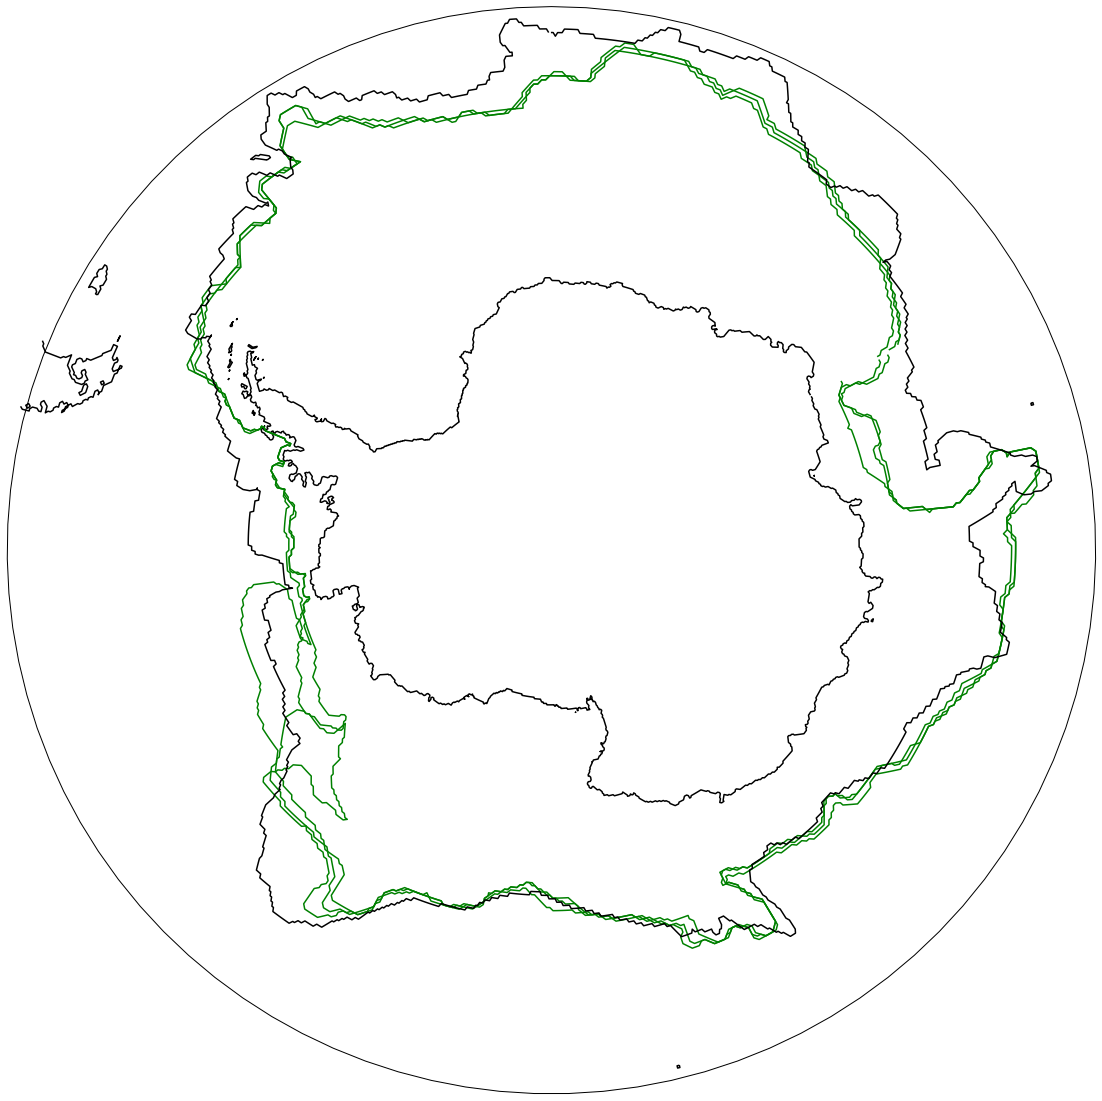

In [12]:
fig = plt.figure(figsize=[20, 20])
proj = ccrs.Stereographic(central_longitude=0,central_latitude=-90)
ax = plt.subplot(projection = proj)
lat_north = -50
so_basics(ax,land_mask_25,geolon_25, geolat_25, lat_north = lat_north, grid = False)

ax.contour(p5_SUCpsig_cycle2_mask.geolon_u, p5_SUCpsig_cycle2_mask.geolat_u,p5_SUCpsig_cycle1_mask.fillna(0), levels = [0,1], colors = 'g',alpha = 1,transform = ccrs.PlateCarree())
ax.contour(p5_SUCpsig_cycle2_mask.geolon_u, p5_SUCpsig_cycle2_mask.geolat_u,p5_SUCpsig_cycle2_mask.fillna(0), levels = [0,1], colors = 'g',alpha = 1,transform = ccrs.PlateCarree())
ax.contour(p5_SUCpsig_cycle3_mask.geolon_u, p5_SUCpsig_cycle3_mask.geolat_u,p5_SUCpsig_cycle3_mask.fillna(0), levels = [0,1], colors = 'g',alpha = 1,transform = ccrs.PlateCarree())


ax.contour(cmems_SUCshh_mask.longitude, cmems_SUCshh_mask.latitude,cmems_SUCshh_mask.fillna(0), levels = [0,1], colors = 'k',alpha = 1,transform = ccrs.PlateCarree())
plt.show()

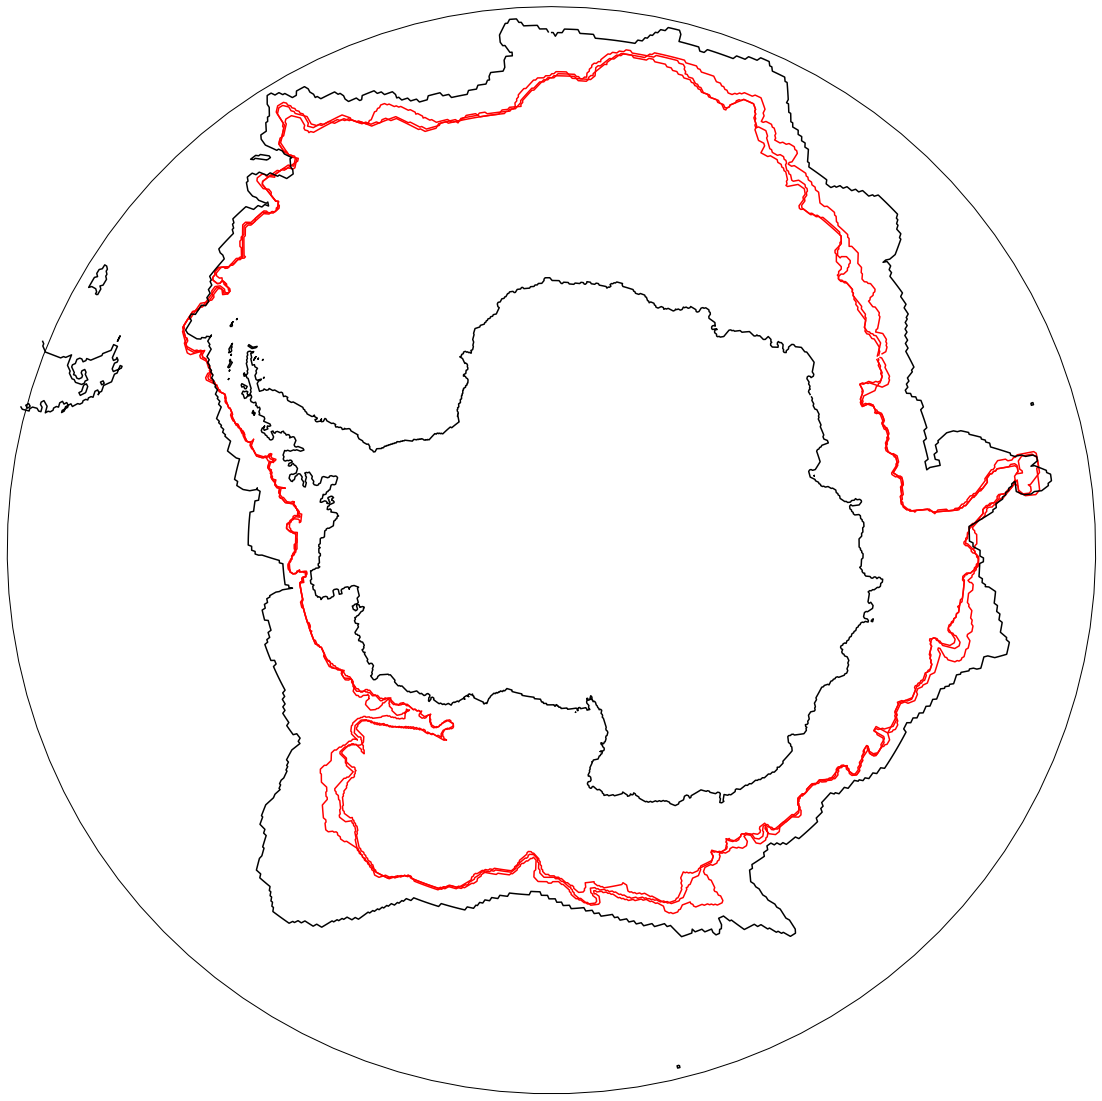

In [13]:
fig = plt.figure(figsize=[20, 20])
proj = ccrs.Stereographic(central_longitude=0,central_latitude=-90)
ax = plt.subplot(projection = proj)
lat_north = -50
so_basics(ax,land_mask_25,geolon_25, geolat_25, lat_north = lat_north, grid = False)

ax.contour(p25_SUCpsig_cycle1_mask.geolon_u, p25_SUCpsig_cycle1_mask.geolat_u,p25_SUCpsig_cycle1_mask.fillna(0), levels = [0,1], colors = 'r',alpha = 1,transform = ccrs.PlateCarree())
ax.contour(p25_SUCpsig_cycle2_mask.geolon_u, p25_SUCpsig_cycle2_mask.geolat_u,p25_SUCpsig_cycle2_mask.fillna(0), levels = [0,1], colors = 'r',alpha = 1,transform = ccrs.PlateCarree())
ax.contour(p25_SUCpsig_cycle1_mask.geolon_u, p25_SUCpsig_cycle1_mask.geolat_u,p25_SUCpsig_cycle3_mask.fillna(0), levels = [0,1], colors = 'r',alpha = 1,transform = ccrs.PlateCarree())

ax.contour(cmems_SUCshh_mask.longitude, cmems_SUCshh_mask.latitude,cmems_SUCshh_mask.fillna(0), levels = [0,1], colors = 'k',alpha = 1,transform = ccrs.PlateCarree())
plt.show()

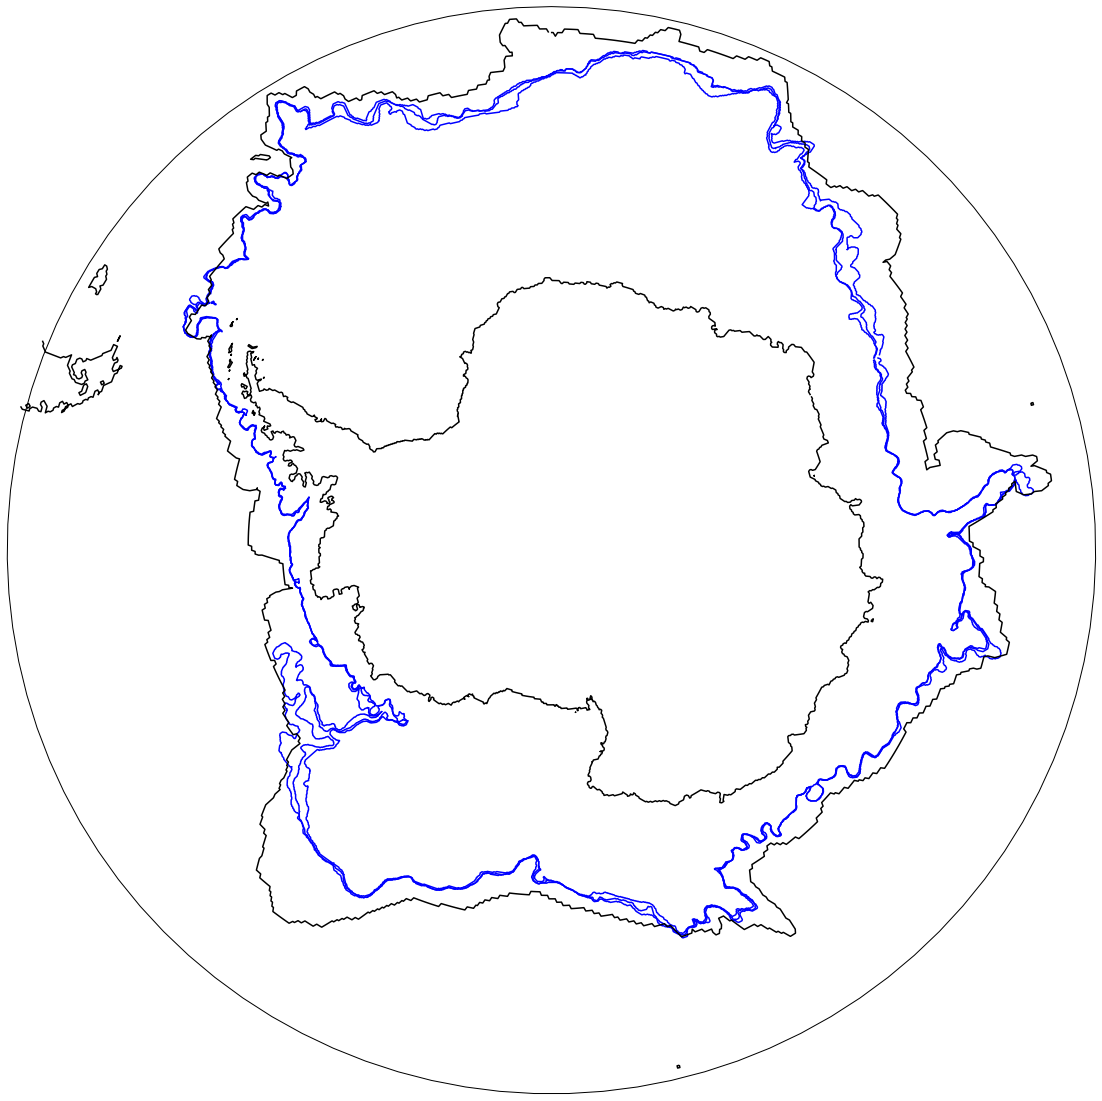

In [14]:
fig = plt.figure(figsize=[20, 20])
proj = ccrs.Stereographic(central_longitude=0,central_latitude=-90)
ax = plt.subplot(projection = proj)
lat_north = -50
so_basics(ax,land_mask_25,geolon_25, geolat_25, lat_north = lat_north, grid = False)

ax.contour(p125_SUCpsig_cycle1_mask.geolon_u, p125_SUCpsig_cycle1_mask.geolat_u,p125_SUCpsig_cycle1_mask.fillna(0), levels = [0,1], colors = 'b',alpha = 1,transform = ccrs.PlateCarree())
ax.contour(p125_SUCpsig_cycle2_mask.geolon_u, p125_SUCpsig_cycle2_mask.geolat_u,p125_SUCpsig_cycle2_mask.fillna(0), levels = [0,1], colors = 'b',alpha = 1,transform = ccrs.PlateCarree())
ax.contour(p125_SUCpsig_cycle3_mask.geolon_u, p125_SUCpsig_cycle3_mask.geolat_u,p125_SUCpsig_cycle3_mask.fillna(0), levels = [0,1], colors = 'b',alpha = 1,transform = ccrs.PlateCarree())

ax.contour(cmems_SUCshh_mask.longitude, cmems_SUCshh_mask.latitude,cmems_SUCshh_mask.fillna(0), levels = [0,1], colors = 'k',alpha = 1,transform = ccrs.PlateCarree())
plt.show()

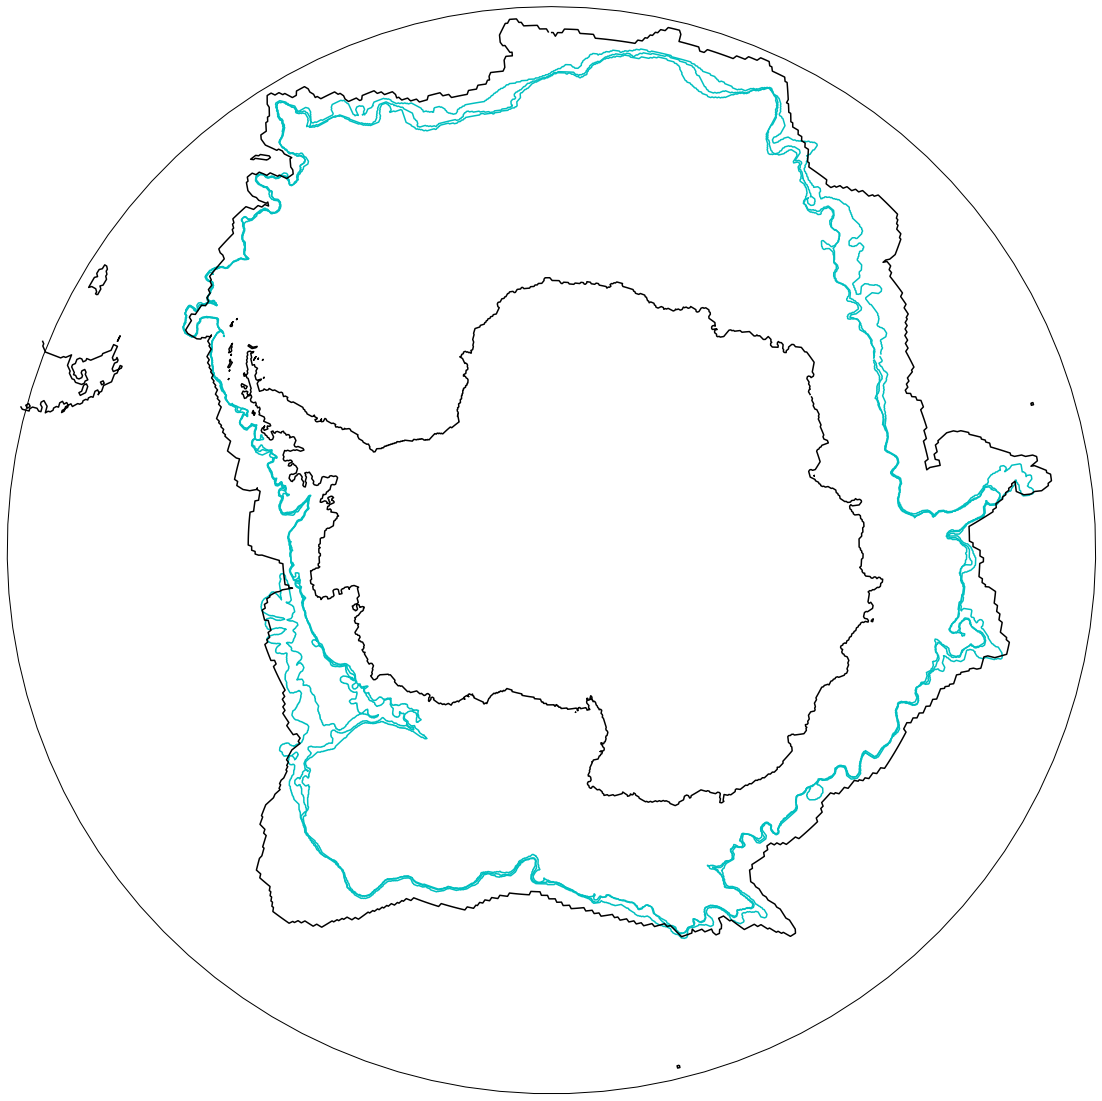

In [15]:
fig = plt.figure(figsize=[20, 20])
proj = ccrs.Stereographic(central_longitude=0,central_latitude=-90)
ax = plt.subplot(projection = proj)
lat_north = -50
so_basics(ax,land_mask_25,geolon_25, geolat_25, lat_north = lat_north, grid = False)

ax.contour(p125_mle_SUCpsig_cycle1_mask.geolon_u, p125_mle_SUCpsig_cycle1_mask.geolat_u,p125_mle_SUCpsig_cycle1_mask.fillna(0), levels = [0,1], colors = 'c',alpha = 1,transform = ccrs.PlateCarree())
ax.contour(p125_mle_SUCpsig_cycle2_mask.geolon_u, p125_mle_SUCpsig_cycle2_mask.geolat_u,p125_mle_SUCpsig_cycle2_mask.fillna(0), levels = [0,1], colors = 'c',alpha = 1,transform = ccrs.PlateCarree())
ax.contour(p125_mle_SUCpsig_cycle3_mask.geolon_u, p125_mle_SUCpsig_cycle3_mask.geolat_u,p125_mle_SUCpsig_cycle3_mask.fillna(0), levels = [0,1], colors = 'c',alpha = 1,transform = ccrs.PlateCarree())


ax.contour(cmems_SUCshh_mask.longitude, cmems_SUCshh_mask.latitude,cmems_SUCshh_mask.fillna(0), levels = [0,1], colors = 'k',alpha = 1,transform = ccrs.PlateCarree())
plt.show()

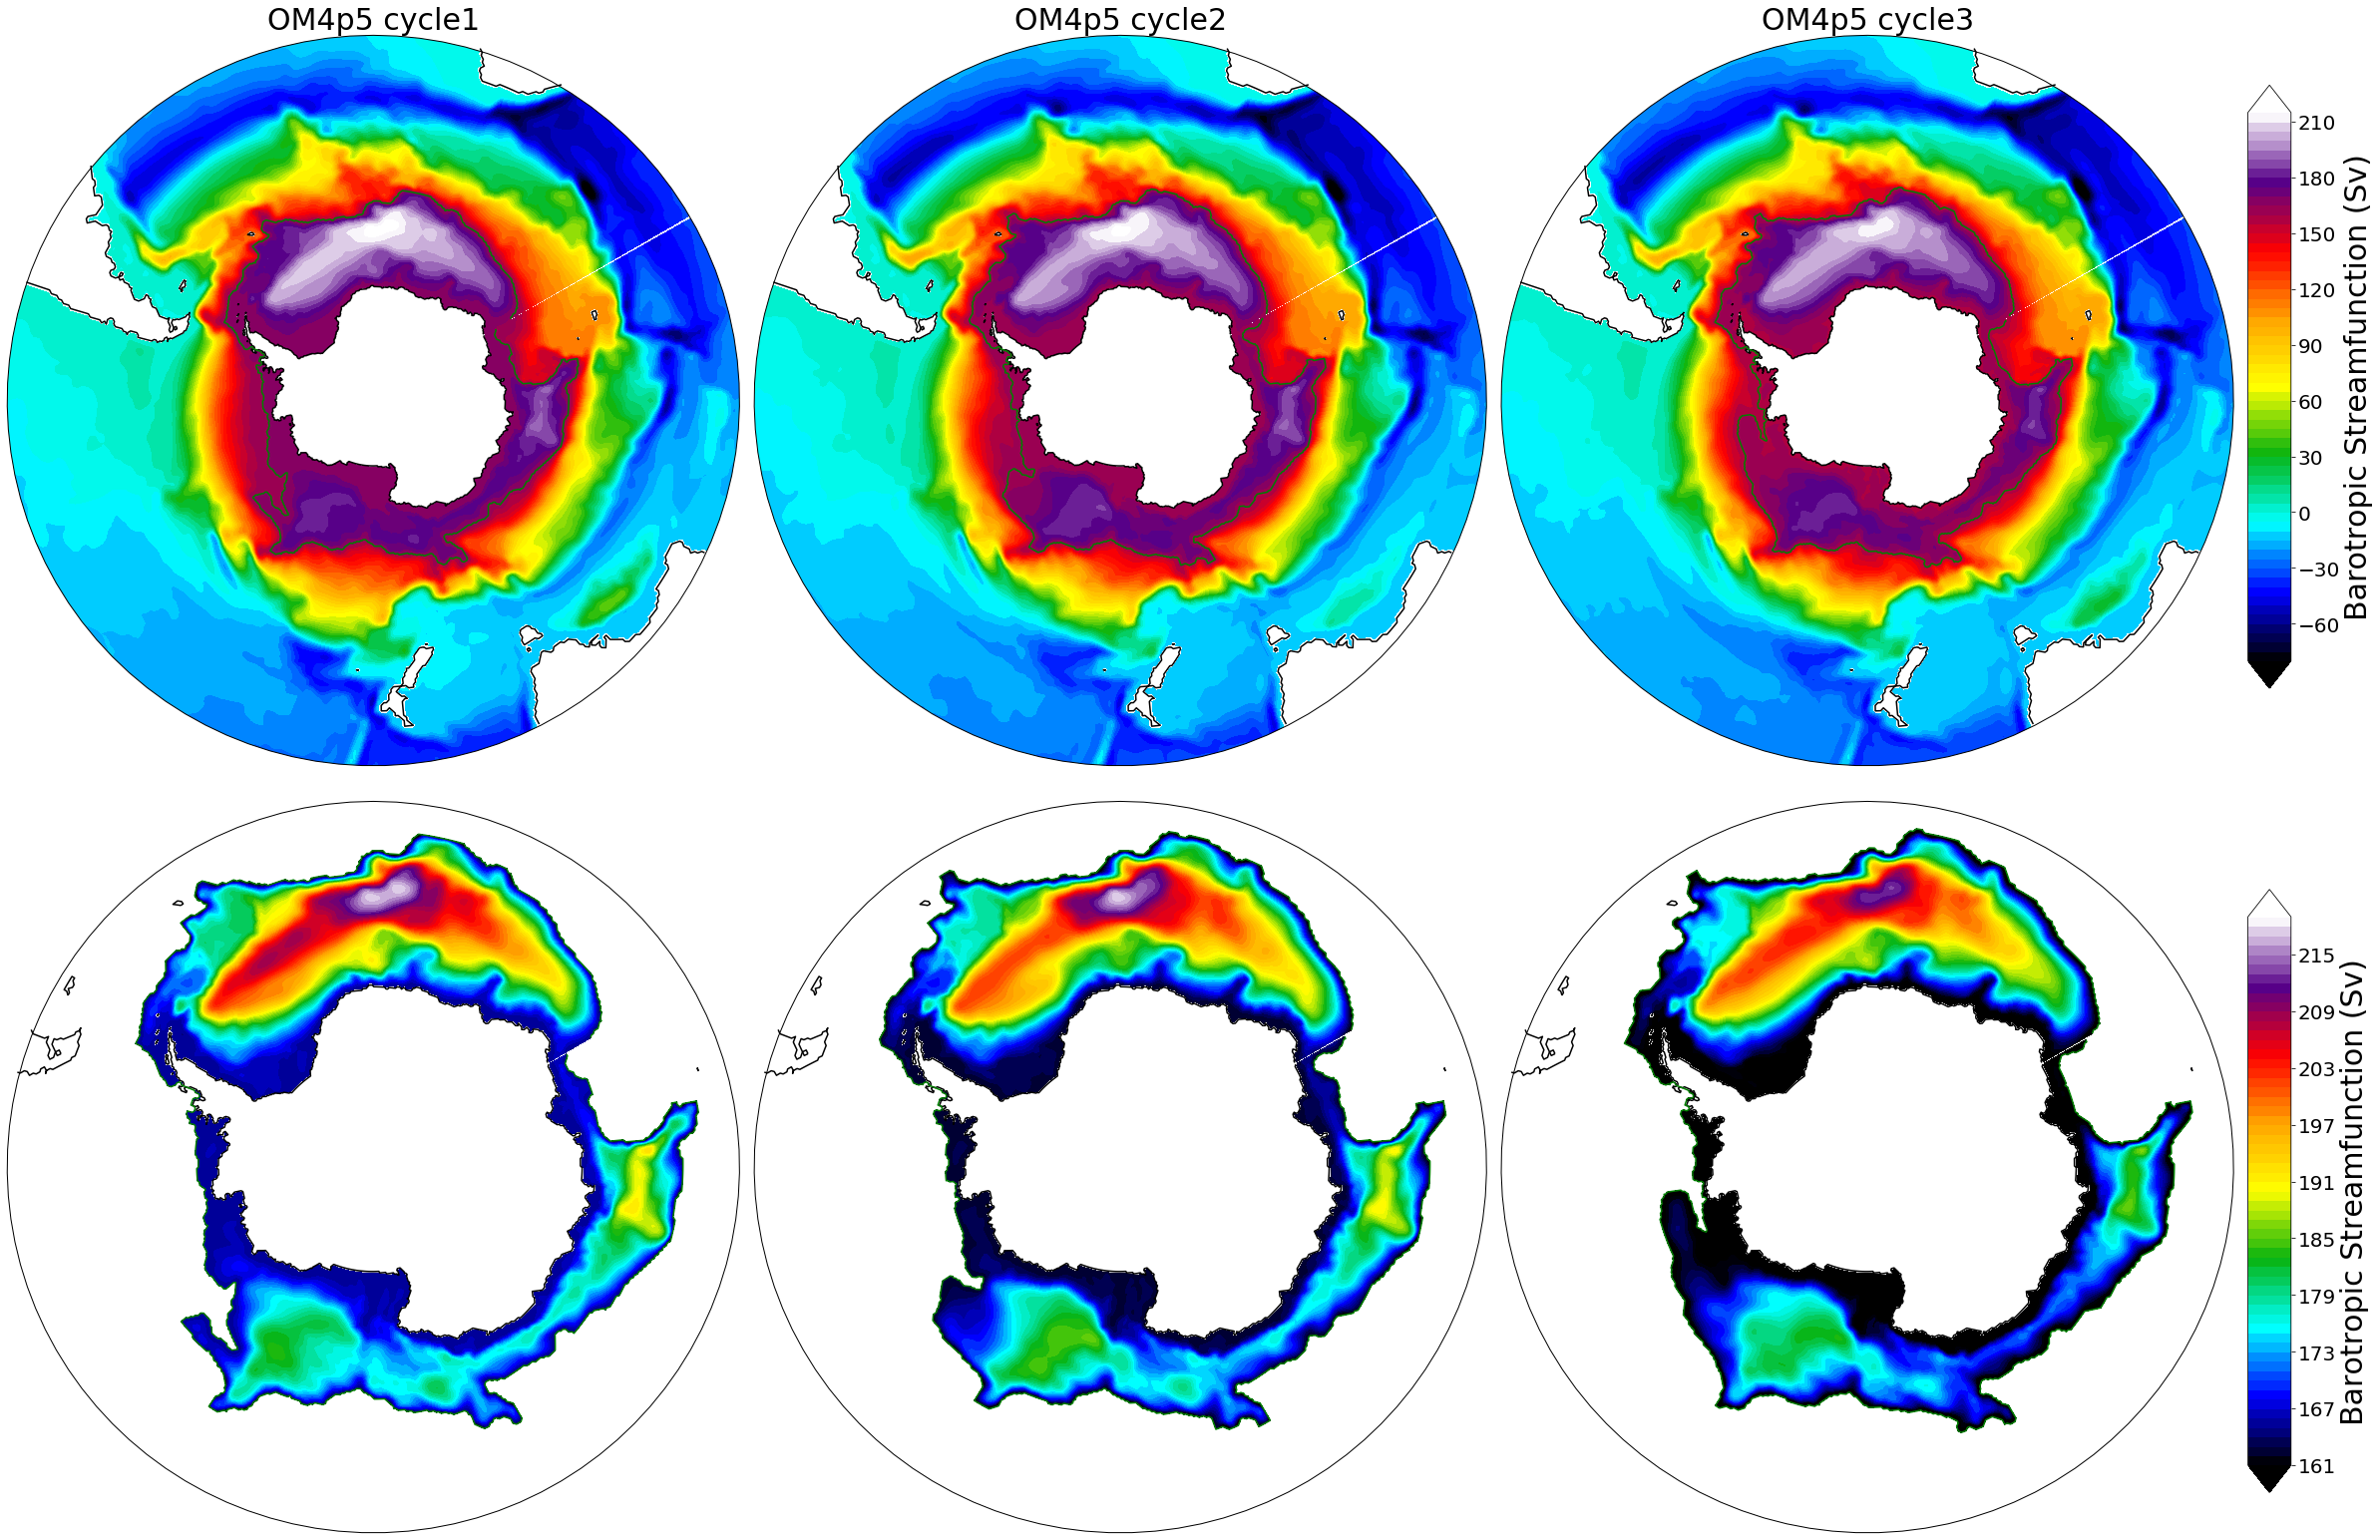

In [73]:
fig = plt.figure(figsize=[40, 28])
gs = gridspec.GridSpec(2,3)
proj = ccrs.Stereographic(central_longitude=0,central_latitude=-90)
ax,ax1,ax2 = plt.subplot(gs[0],projection = proj),plt.subplot(gs[1],projection = proj), plt.subplot(gs[2],projection = proj)
ax3,ax4,ax5 = plt.subplot(gs[3],projection = proj),plt.subplot(gs[4],projection = proj), plt.subplot(gs[5],projection = proj)
gs.update(wspace = 0.02, hspace = 0.02)


## p5 ##

land_mask =land_mask_5
geolon =geolon_5
geolat =geolat_5

lat_north = -30
so_basics(ax,land_mask,geolon, geolat, lat_north = lat_north, grid = False)
so_basics(ax1,land_mask,geolon, geolat, lat_north = lat_north, grid = False)
so_basics(ax2,land_mask,geolon, geolat, lat_north = lat_north, grid = False)
lat_north = -50
so_basics(ax3,land_mask,geolon, geolat, lat_north = lat_north, grid = False)
so_basics(ax4,land_mask,geolon, geolat, lat_north = lat_north, grid = False)
so_basics(ax5,land_mask,geolon, geolat, lat_north = lat_north, grid = False)

lvls = np.arange(-80, 220, 5)
cmap = nclcmaps.cmap('BkBlAqGrYeOrReViWh200')
cf = ax.contourf(geolon, geolat,p5_SUCpsig_cycle1_psig*(land_mask.where(land_mask>0)), levels = lvls, cmap = cmap, extend = 'both', transform = ccrs.PlateCarree())
ax.contour(geolon,geolat,(p5_SUCpsig_cycle1_mask*0).fillna(1), levels = [0,1], colors = 'g',alpha = 1,transform = ccrs.PlateCarree())
cf = ax1.contourf(geolon, geolat,p5_SUCpsig_cycle2_psig*(land_mask.where(land_mask>0)), levels = lvls, cmap = cmap, extend = 'both', transform = ccrs.PlateCarree())
ax1.contour(geolon,geolat,(p5_SUCpsig_cycle2_mask*0).fillna(1), levels = [0,1], colors = 'g',alpha = 1,transform = ccrs.PlateCarree())
cf = ax2.contourf(geolon, geolat,p5_SUCpsig_cycle3_psig*(land_mask.where(land_mask>0)), levels = lvls, cmap = cmap, extend = 'both', transform = ccrs.PlateCarree())
ax2.contour(geolon,geolat,(p5_SUCpsig_cycle3_mask*0).fillna(1), levels = [0,1], colors = 'g',alpha = 1,transform = ccrs.PlateCarree())
ax.set_title('OM4p5 cycle1', fontsize = 30)
ax1.set_title('OM4p5 cycle2', fontsize = 30)
ax2.set_title('OM4p5 cycle3', fontsize = 30)
cax = fig.add_axes([0.905, 0.55, 0.015, 0.3])
cbar=plt.colorbar(cf,cax = cax,orientation='vertical',shrink = 0.5)
cax.set_ylabel('Barotropic Streamfunction (Sv)', fontsize = 30)

lvls = np.arange(161, 220, 1)
cmap = nclcmaps.cmap('BkBlAqGrYeOrReViWh200')
plot = p5_SUCpsig_cycle1_psig*(land_mask.where(land_mask>0))
plot = plot * p5_SUCpsig_cycle1_mask.where(p5_SUCpsig_cycle1_mask>0)
cf = ax3.contourf(geolon, geolat,plot, levels = lvls, cmap = cmap, extend = 'both', transform = ccrs.PlateCarree())
ax3.contour(geolon,geolat,(p5_SUCpsig_cycle1_mask*0).fillna(1), levels = [0,1], colors = 'g',alpha = 1,transform = ccrs.PlateCarree())
plot = p5_SUCpsig_cycle2_psig*(land_mask.where(land_mask>0))
plot = plot * p5_SUCpsig_cycle2_mask.where(p5_SUCpsig_cycle2_mask>0)
cf = ax4.contourf(geolon, geolat,plot, levels = lvls, cmap = cmap, extend = 'both', transform = ccrs.PlateCarree())
ax4.contour(geolon,geolat,(p5_SUCpsig_cycle2_mask*0).fillna(1), levels = [0,1], colors = 'g',alpha = 1,transform = ccrs.PlateCarree())
plot = p5_SUCpsig_cycle3_psig*(land_mask.where(land_mask>0))
plot = plot * p5_SUCpsig_cycle3_mask.where(p5_SUCpsig_cycle3_mask>0)
cf = ax5.contourf(geolon, geolat,plot, levels = lvls, cmap = cmap, extend = 'both', transform = ccrs.PlateCarree())
ax5.contour(geolon,geolat,(p5_SUCpsig_cycle3_mask*0).fillna(1), levels = [0,1], colors = 'g',alpha = 1,transform = ccrs.PlateCarree())
cax = fig.add_axes([0.905, 0.15, 0.015, 0.3])
cbar=plt.colorbar(cf,cax = cax,orientation='vertical',shrink = 0.5)
cax.set_ylabel('Barotropic Streamfunction (Sv)', fontsize = 30)

figurepath = 'p5_barotropic_streamfunction_SUC.png'
plt.savefig(figurepath, dpi=None, facecolor='w', edgecolor='w',orientation='portrait', papertype=None, format='png',transparent=False, bbox_inches='tight', pad_inches=0.15,frameon=None)

plt.show()

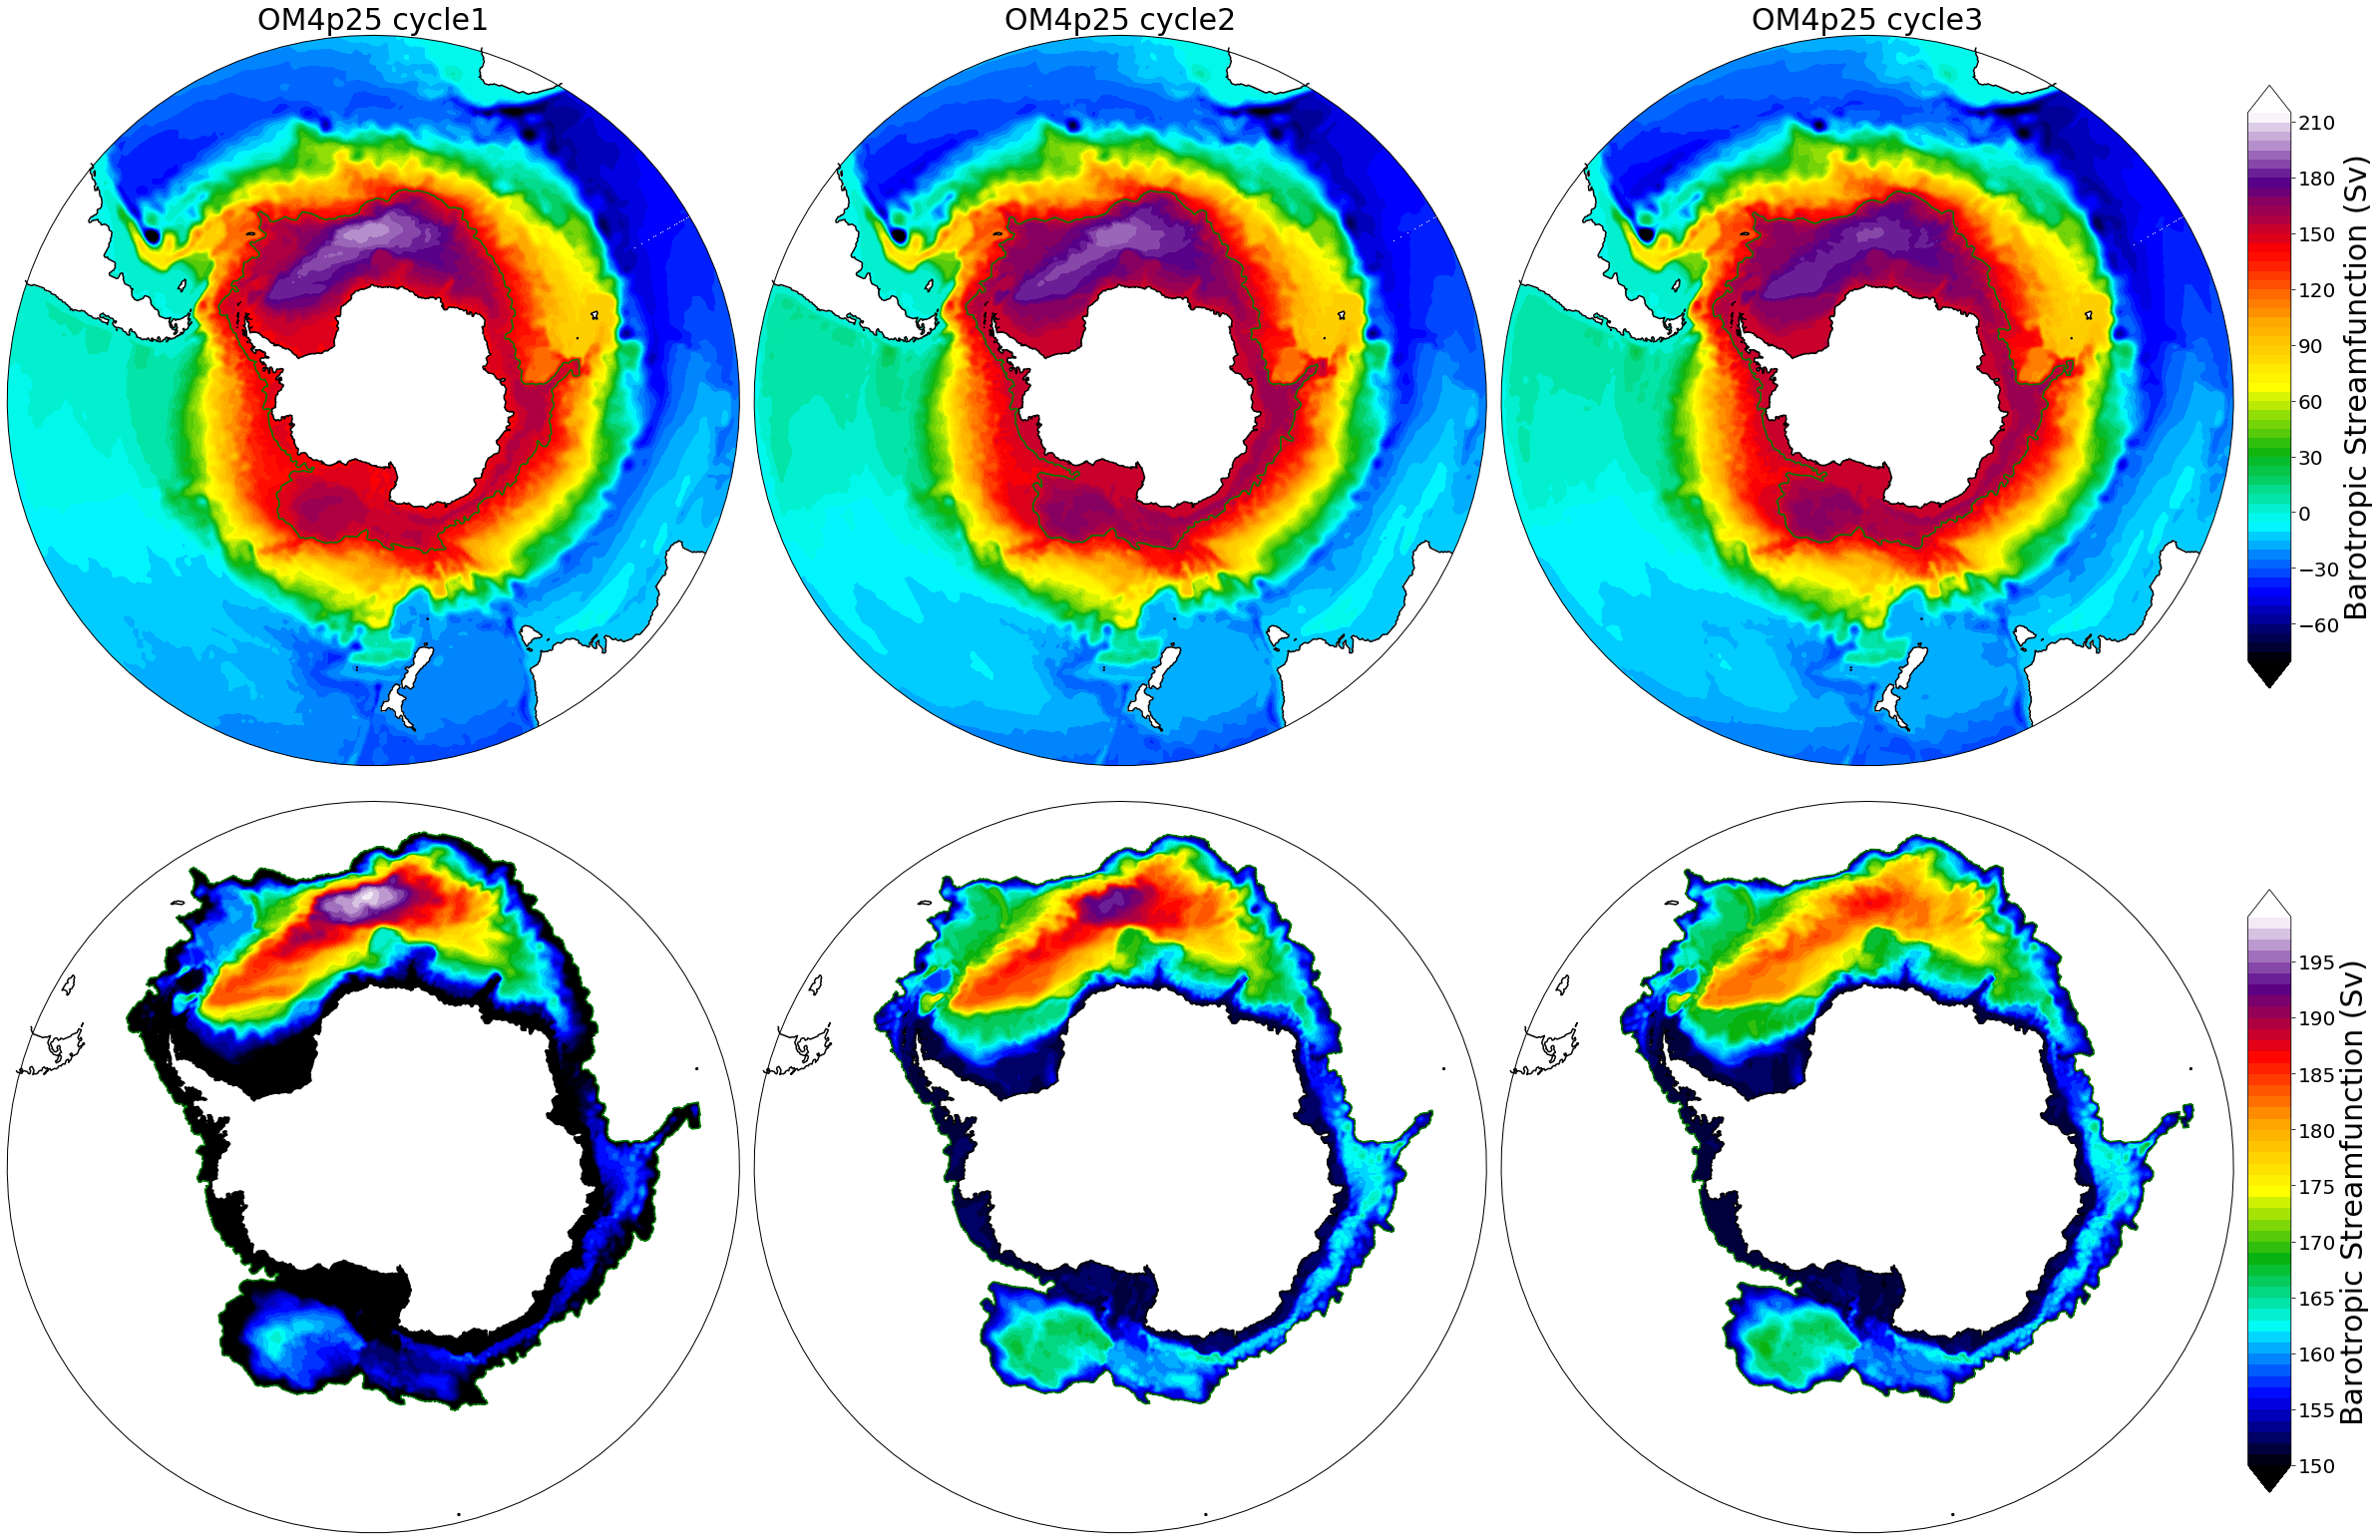

In [76]:
fig = plt.figure(figsize=[40, 28])
gs = gridspec.GridSpec(2,3)
proj = ccrs.Stereographic(central_longitude=0,central_latitude=-90)
ax,ax1,ax2 = plt.subplot(gs[0],projection = proj),plt.subplot(gs[1],projection = proj), plt.subplot(gs[2],projection = proj)
ax3,ax4,ax5 = plt.subplot(gs[3],projection = proj),plt.subplot(gs[4],projection = proj), plt.subplot(gs[5],projection = proj)
gs.update(wspace = 0.02, hspace = 0.02)

## p25 ##

land_mask =land_mask_25
geolon =geolon_25
geolat =geolat_25

lat_north = -30
so_basics(ax,land_mask,geolon, geolat, lat_north = lat_north, grid = False)
so_basics(ax1,land_mask,geolon, geolat, lat_north = lat_north, grid = False)
so_basics(ax2,land_mask,geolon, geolat, lat_north = lat_north, grid = False)
lat_north = -50
so_basics(ax3,land_mask,geolon, geolat, lat_north = lat_north, grid = False)
so_basics(ax4,land_mask,geolon, geolat, lat_north = lat_north, grid = False)
so_basics(ax5,land_mask,geolon, geolat, lat_north = lat_north, grid = False)

lvls = np.arange(-80, 220, 5)
cmap = nclcmaps.cmap('BkBlAqGrYeOrReViWh200')
cf = ax.contourf(geolon, geolat,p25_SUCpsig_cycle1_psig*(land_mask.where(land_mask>0)), levels = lvls, cmap = cmap, extend = 'both', transform = ccrs.PlateCarree())
ax.contour(geolon,geolat,(p25_SUCpsig_cycle1_mask*0).fillna(1), levels = [0,1], colors = 'g',alpha = 1,transform = ccrs.PlateCarree())
cf = ax1.contourf(geolon, geolat,p25_SUCpsig_cycle2_psig*(land_mask.where(land_mask>0)), levels = lvls, cmap = cmap, extend = 'both', transform = ccrs.PlateCarree())
ax1.contour(geolon,geolat,(p25_SUCpsig_cycle2_mask*0).fillna(1), levels = [0,1], colors = 'g',alpha = 1,transform = ccrs.PlateCarree())
cf = ax2.contourf(geolon, geolat,p25_SUCpsig_cycle3_psig*(land_mask.where(land_mask>0)), levels = lvls, cmap = cmap, extend = 'both', transform = ccrs.PlateCarree())
ax2.contour(geolon,geolat,(p25_SUCpsig_cycle3_mask*0).fillna(1), levels = [0,1], colors = 'g',alpha = 1,transform = ccrs.PlateCarree())
ax.set_title('OM4p25 cycle1', fontsize = 30)
ax1.set_title('OM4p25 cycle2', fontsize = 30)
ax2.set_title('OM4p25 cycle3', fontsize = 30)
cax = fig.add_axes([0.905, 0.55, 0.015, 0.3])
cbar=plt.colorbar(cf,cax = cax,orientation='vertical',shrink = 0.5)
cax.set_ylabel('Barotropic Streamfunction (Sv)', fontsize = 30)

lvls = np.arange(150, 200, 1)
cmap = nclcmaps.cmap('BkBlAqGrYeOrReViWh200')
plot = p25_SUCpsig_cycle1_psig*(land_mask.where(land_mask>0))
plot = plot * p25_SUCpsig_cycle1_mask.where(p25_SUCpsig_cycle1_mask>0)
cf = ax3.contourf(geolon, geolat,plot, levels = lvls, cmap = cmap, extend = 'both', transform = ccrs.PlateCarree())
ax3.contour(geolon,geolat,(p25_SUCpsig_cycle1_mask*0).fillna(1), levels = [0,1], colors = 'g',alpha = 1,transform = ccrs.PlateCarree())
plot = p25_SUCpsig_cycle2_psig*(land_mask.where(land_mask>0))
plot = plot * p25_SUCpsig_cycle2_mask.where(p25_SUCpsig_cycle2_mask>0)
cf = ax4.contourf(geolon, geolat,plot, levels = lvls, cmap = cmap, extend = 'both', transform = ccrs.PlateCarree())
ax4.contour(geolon,geolat,(p25_SUCpsig_cycle2_mask*0).fillna(1), levels = [0,1], colors = 'g',alpha = 1,transform = ccrs.PlateCarree())
plot = p25_SUCpsig_cycle3_psig*(land_mask.where(land_mask>0))
plot = plot * p25_SUCpsig_cycle3_mask.where(p25_SUCpsig_cycle3_mask>0)
cf = ax5.contourf(geolon, geolat,plot, levels = lvls, cmap = cmap, extend = 'both', transform = ccrs.PlateCarree())
ax5.contour(geolon,geolat,(p25_SUCpsig_cycle3_mask*0).fillna(1), levels = [0,1], colors = 'g',alpha = 1,transform = ccrs.PlateCarree())
cax = fig.add_axes([0.905, 0.15, 0.015, 0.3])
cbar=plt.colorbar(cf,cax = cax,orientation='vertical',shrink = 0.5)
cax.set_ylabel('Barotropic Streamfunction (Sv)', fontsize = 30)

figurepath = 'p25_barotropic_streamfunction_SUC.png'
plt.savefig(figurepath, dpi=None, facecolor='w', edgecolor='w',orientation='portrait', papertype=None, format='png',transparent=False, bbox_inches='tight', pad_inches=0.15,frameon=None)

plt.show()

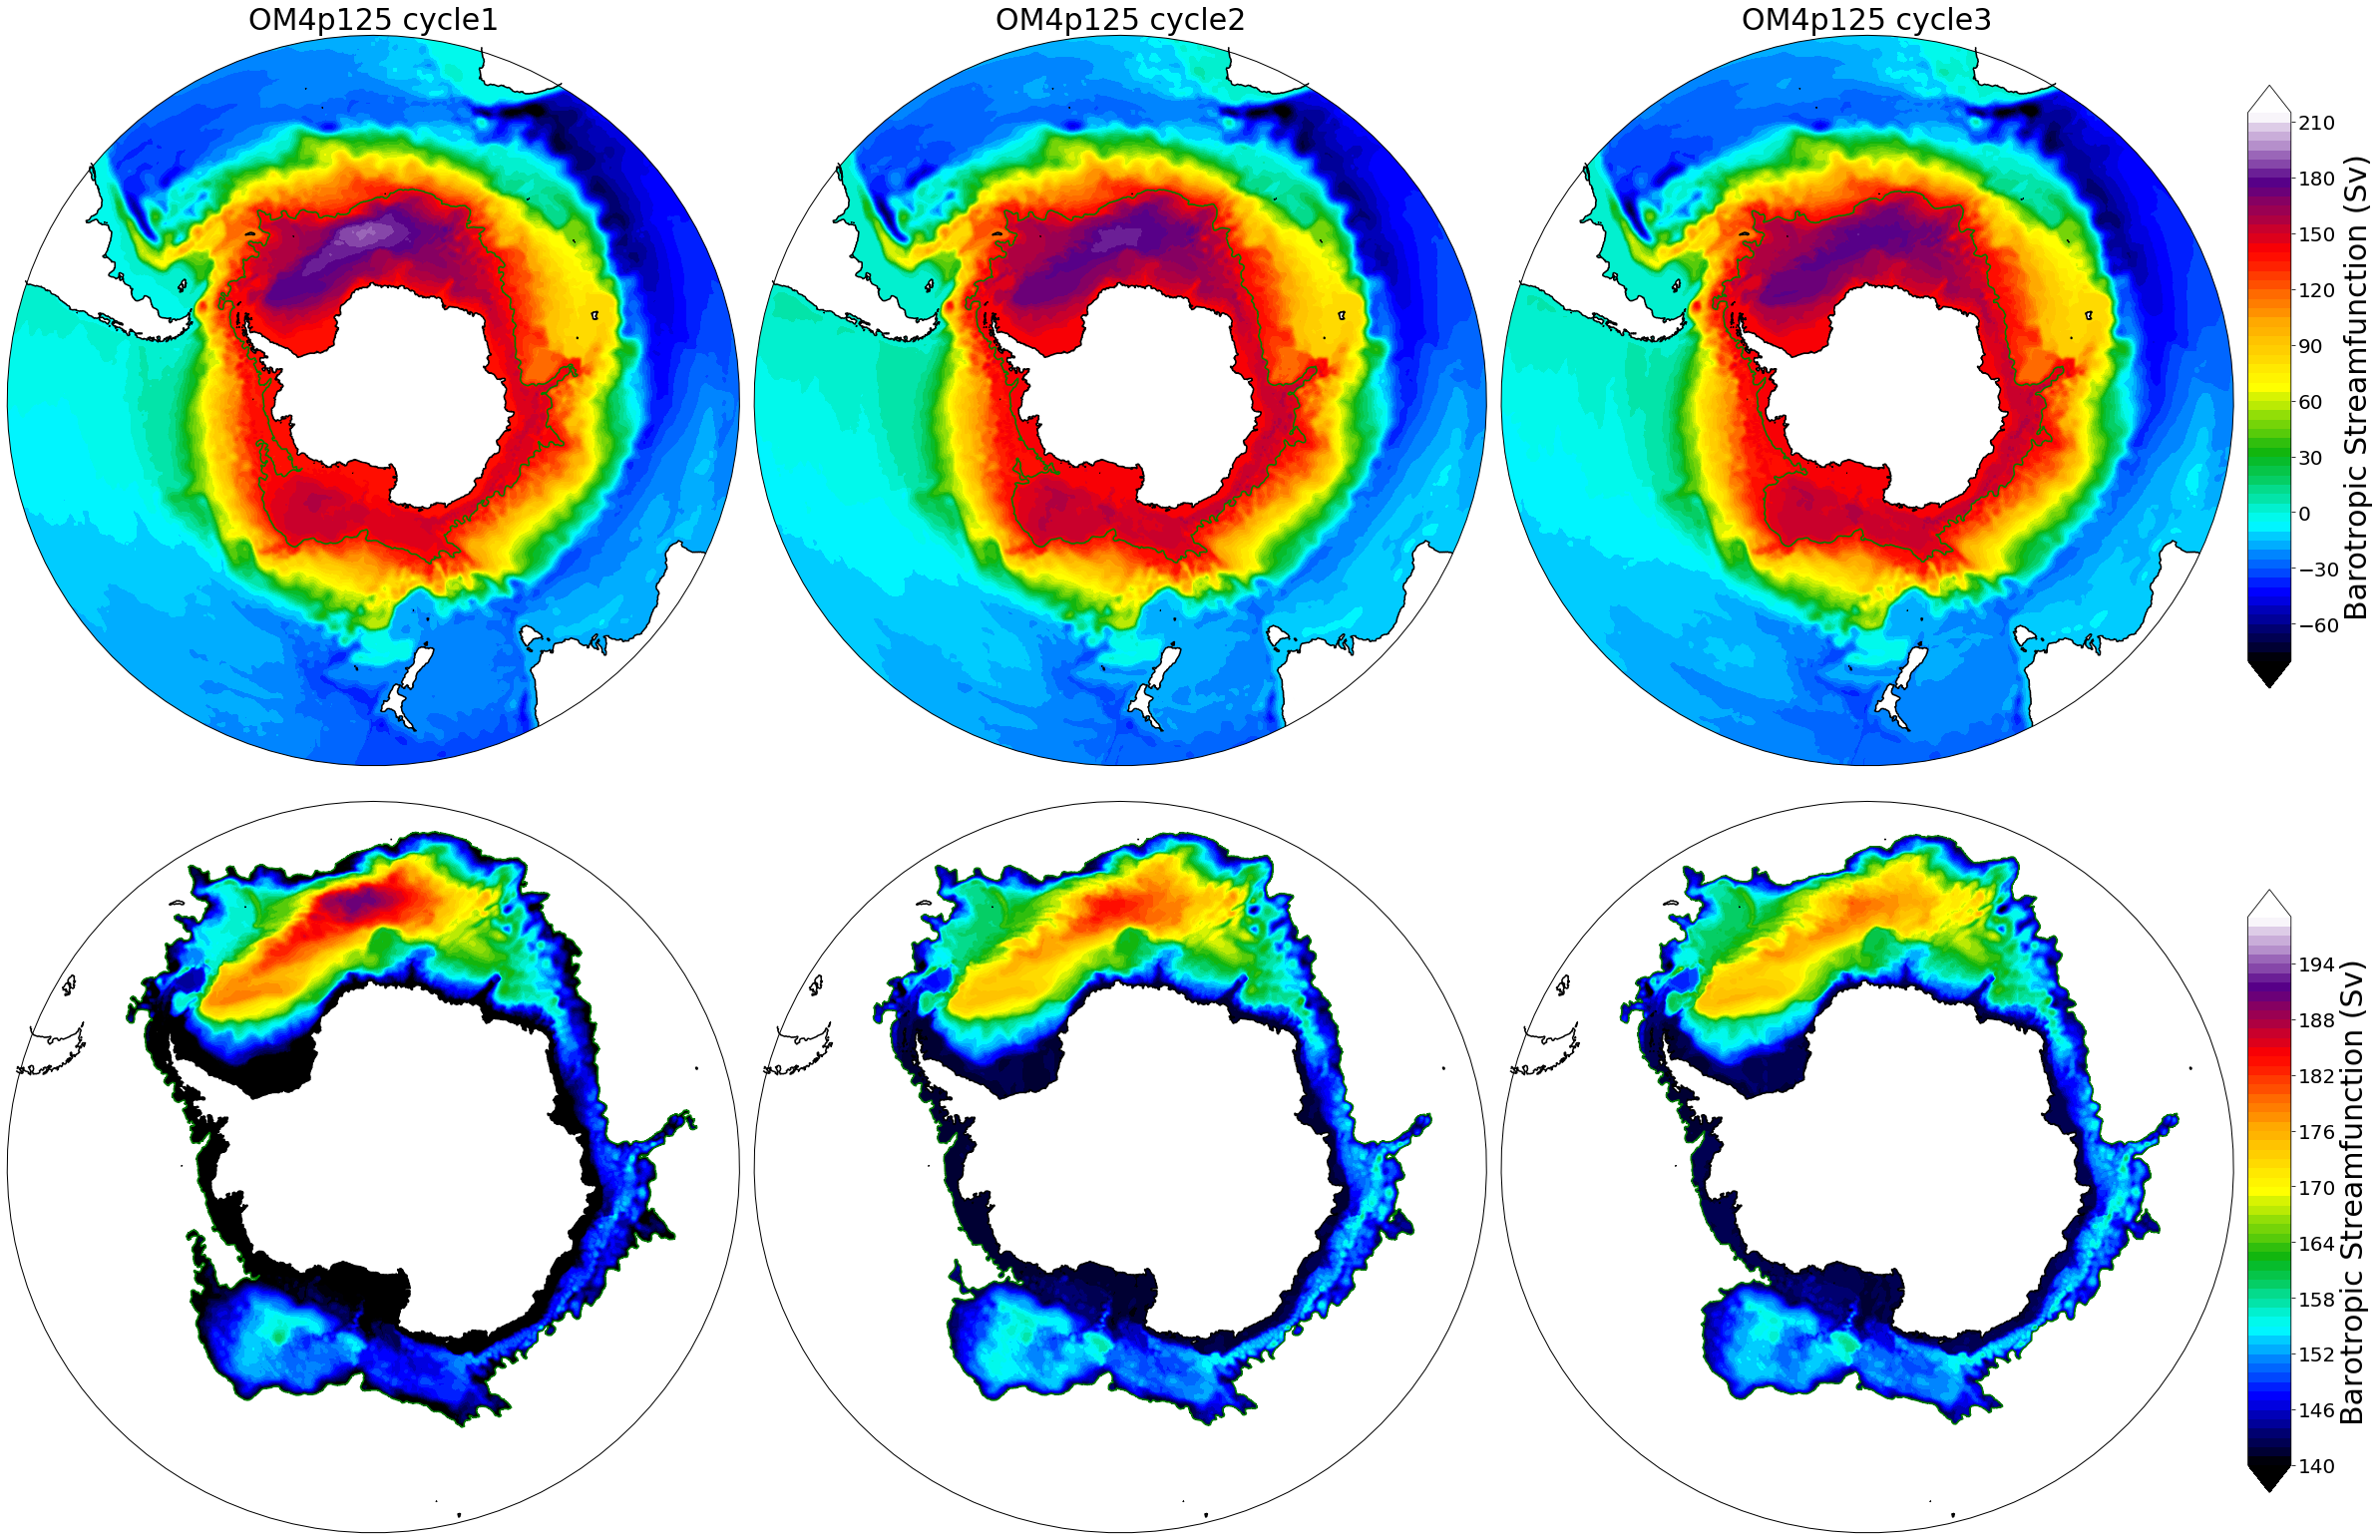

In [77]:
fig = plt.figure(figsize=[40, 28])
gs = gridspec.GridSpec(2,3)
proj = ccrs.Stereographic(central_longitude=0,central_latitude=-90)
ax,ax1,ax2 = plt.subplot(gs[0],projection = proj),plt.subplot(gs[1],projection = proj), plt.subplot(gs[2],projection = proj)
ax3,ax4,ax5 = plt.subplot(gs[3],projection = proj),plt.subplot(gs[4],projection = proj), plt.subplot(gs[5],projection = proj)
gs.update(wspace = 0.02, hspace = 0.02)
lat_north = -50

## p125 ##

land_mask =land_mask_125
geolon =geolon_125
geolat =geolat_125

lat_north = -30
so_basics(ax,land_mask,geolon, geolat, lat_north = lat_north, grid = False)
so_basics(ax1,land_mask,geolon, geolat, lat_north = lat_north, grid = False)
so_basics(ax2,land_mask,geolon, geolat, lat_north = lat_north, grid = False)
lat_north = -50
so_basics(ax3,land_mask,geolon, geolat, lat_north = lat_north, grid = False)
so_basics(ax4,land_mask,geolon, geolat, lat_north = lat_north, grid = False)
so_basics(ax5,land_mask,geolon, geolat, lat_north = lat_north, grid = False)

lvls = np.arange(-80, 220, 5)
cmap = nclcmaps.cmap('BkBlAqGrYeOrReViWh200')
cf = ax.contourf(geolon, geolat,p125_SUCpsig_cycle1_psig*(land_mask.where(land_mask>0)), levels = lvls, cmap = cmap, extend = 'both', transform = ccrs.PlateCarree())
ax.contour(geolon,geolat,(p125_SUCpsig_cycle1_mask*0).fillna(1), levels = [0,1], colors = 'g',alpha = 1,transform = ccrs.PlateCarree())
cf = ax1.contourf(geolon, geolat,p125_SUCpsig_cycle2_psig*(land_mask.where(land_mask>0)), levels = lvls, cmap = cmap, extend = 'both', transform = ccrs.PlateCarree())
ax1.contour(geolon,geolat,(p125_SUCpsig_cycle2_mask*0).fillna(1), levels = [0,1], colors = 'g',alpha = 1,transform = ccrs.PlateCarree())
cf = ax2.contourf(geolon, geolat,p125_SUCpsig_cycle3_psig*(land_mask.where(land_mask>0)), levels = lvls, cmap = cmap, extend = 'both', transform = ccrs.PlateCarree())
ax2.contour(geolon,geolat,(p125_SUCpsig_cycle3_mask*0).fillna(1), levels = [0,1], colors = 'g',alpha = 1,transform = ccrs.PlateCarree())
ax.set_title('OM4p125 cycle1', fontsize = 30)
ax1.set_title('OM4p125 cycle2', fontsize = 30)
ax2.set_title('OM4p125 cycle3', fontsize = 30)
cax = fig.add_axes([0.905, 0.55, 0.015, 0.3])
cbar=plt.colorbar(cf,cax = cax,orientation='vertical',shrink = 0.5)
cax.set_ylabel('Barotropic Streamfunction (Sv)', fontsize = 30)

lvls = np.arange(140, 200, 1)
cmap = nclcmaps.cmap('BkBlAqGrYeOrReViWh200')
plot = p125_SUCpsig_cycle1_psig*(land_mask.where(land_mask>0))
plot = plot * p125_SUCpsig_cycle1_mask.where(p125_SUCpsig_cycle1_mask>0)
cf = ax3.contourf(geolon, geolat,plot, levels = lvls, cmap = cmap, extend = 'both', transform = ccrs.PlateCarree())
ax3.contour(geolon,geolat,(p125_SUCpsig_cycle1_mask*0).fillna(1), levels = [0,1], colors = 'g',alpha = 1,transform = ccrs.PlateCarree())
plot = p125_SUCpsig_cycle2_psig*(land_mask.where(land_mask>0))
plot = plot * p125_SUCpsig_cycle2_mask.where(p125_SUCpsig_cycle2_mask>0)
cf = ax4.contourf(geolon, geolat,plot, levels = lvls, cmap = cmap, extend = 'both', transform = ccrs.PlateCarree())
ax4.contour(geolon,geolat,(p125_SUCpsig_cycle2_mask*0).fillna(1), levels = [0,1], colors = 'g',alpha = 1,transform = ccrs.PlateCarree())
plot = p125_SUCpsig_cycle3_psig*(land_mask.where(land_mask>0))
plot = plot * p125_SUCpsig_cycle3_mask.where(p125_SUCpsig_cycle3_mask>0)
cf = ax5.contourf(geolon, geolat,plot, levels = lvls, cmap = cmap, extend = 'both', transform = ccrs.PlateCarree())
ax5.contour(geolon,geolat,(p125_SUCpsig_cycle3_mask*0).fillna(1), levels = [0,1], colors = 'g',alpha = 1,transform = ccrs.PlateCarree())
cax = fig.add_axes([0.905, 0.15, 0.015, 0.3])
cbar=plt.colorbar(cf,cax = cax,orientation='vertical',shrink = 0.5)
cax.set_ylabel('Barotropic Streamfunction (Sv)', fontsize = 30)

figurepath = 'p125_barotropic_streamfunction_SUC.png'
plt.savefig(figurepath, dpi=None, facecolor='w', edgecolor='w',orientation='portrait', papertype=None, format='png',transparent=False, bbox_inches='tight', pad_inches=0.15,frameon=None)

plt.show()

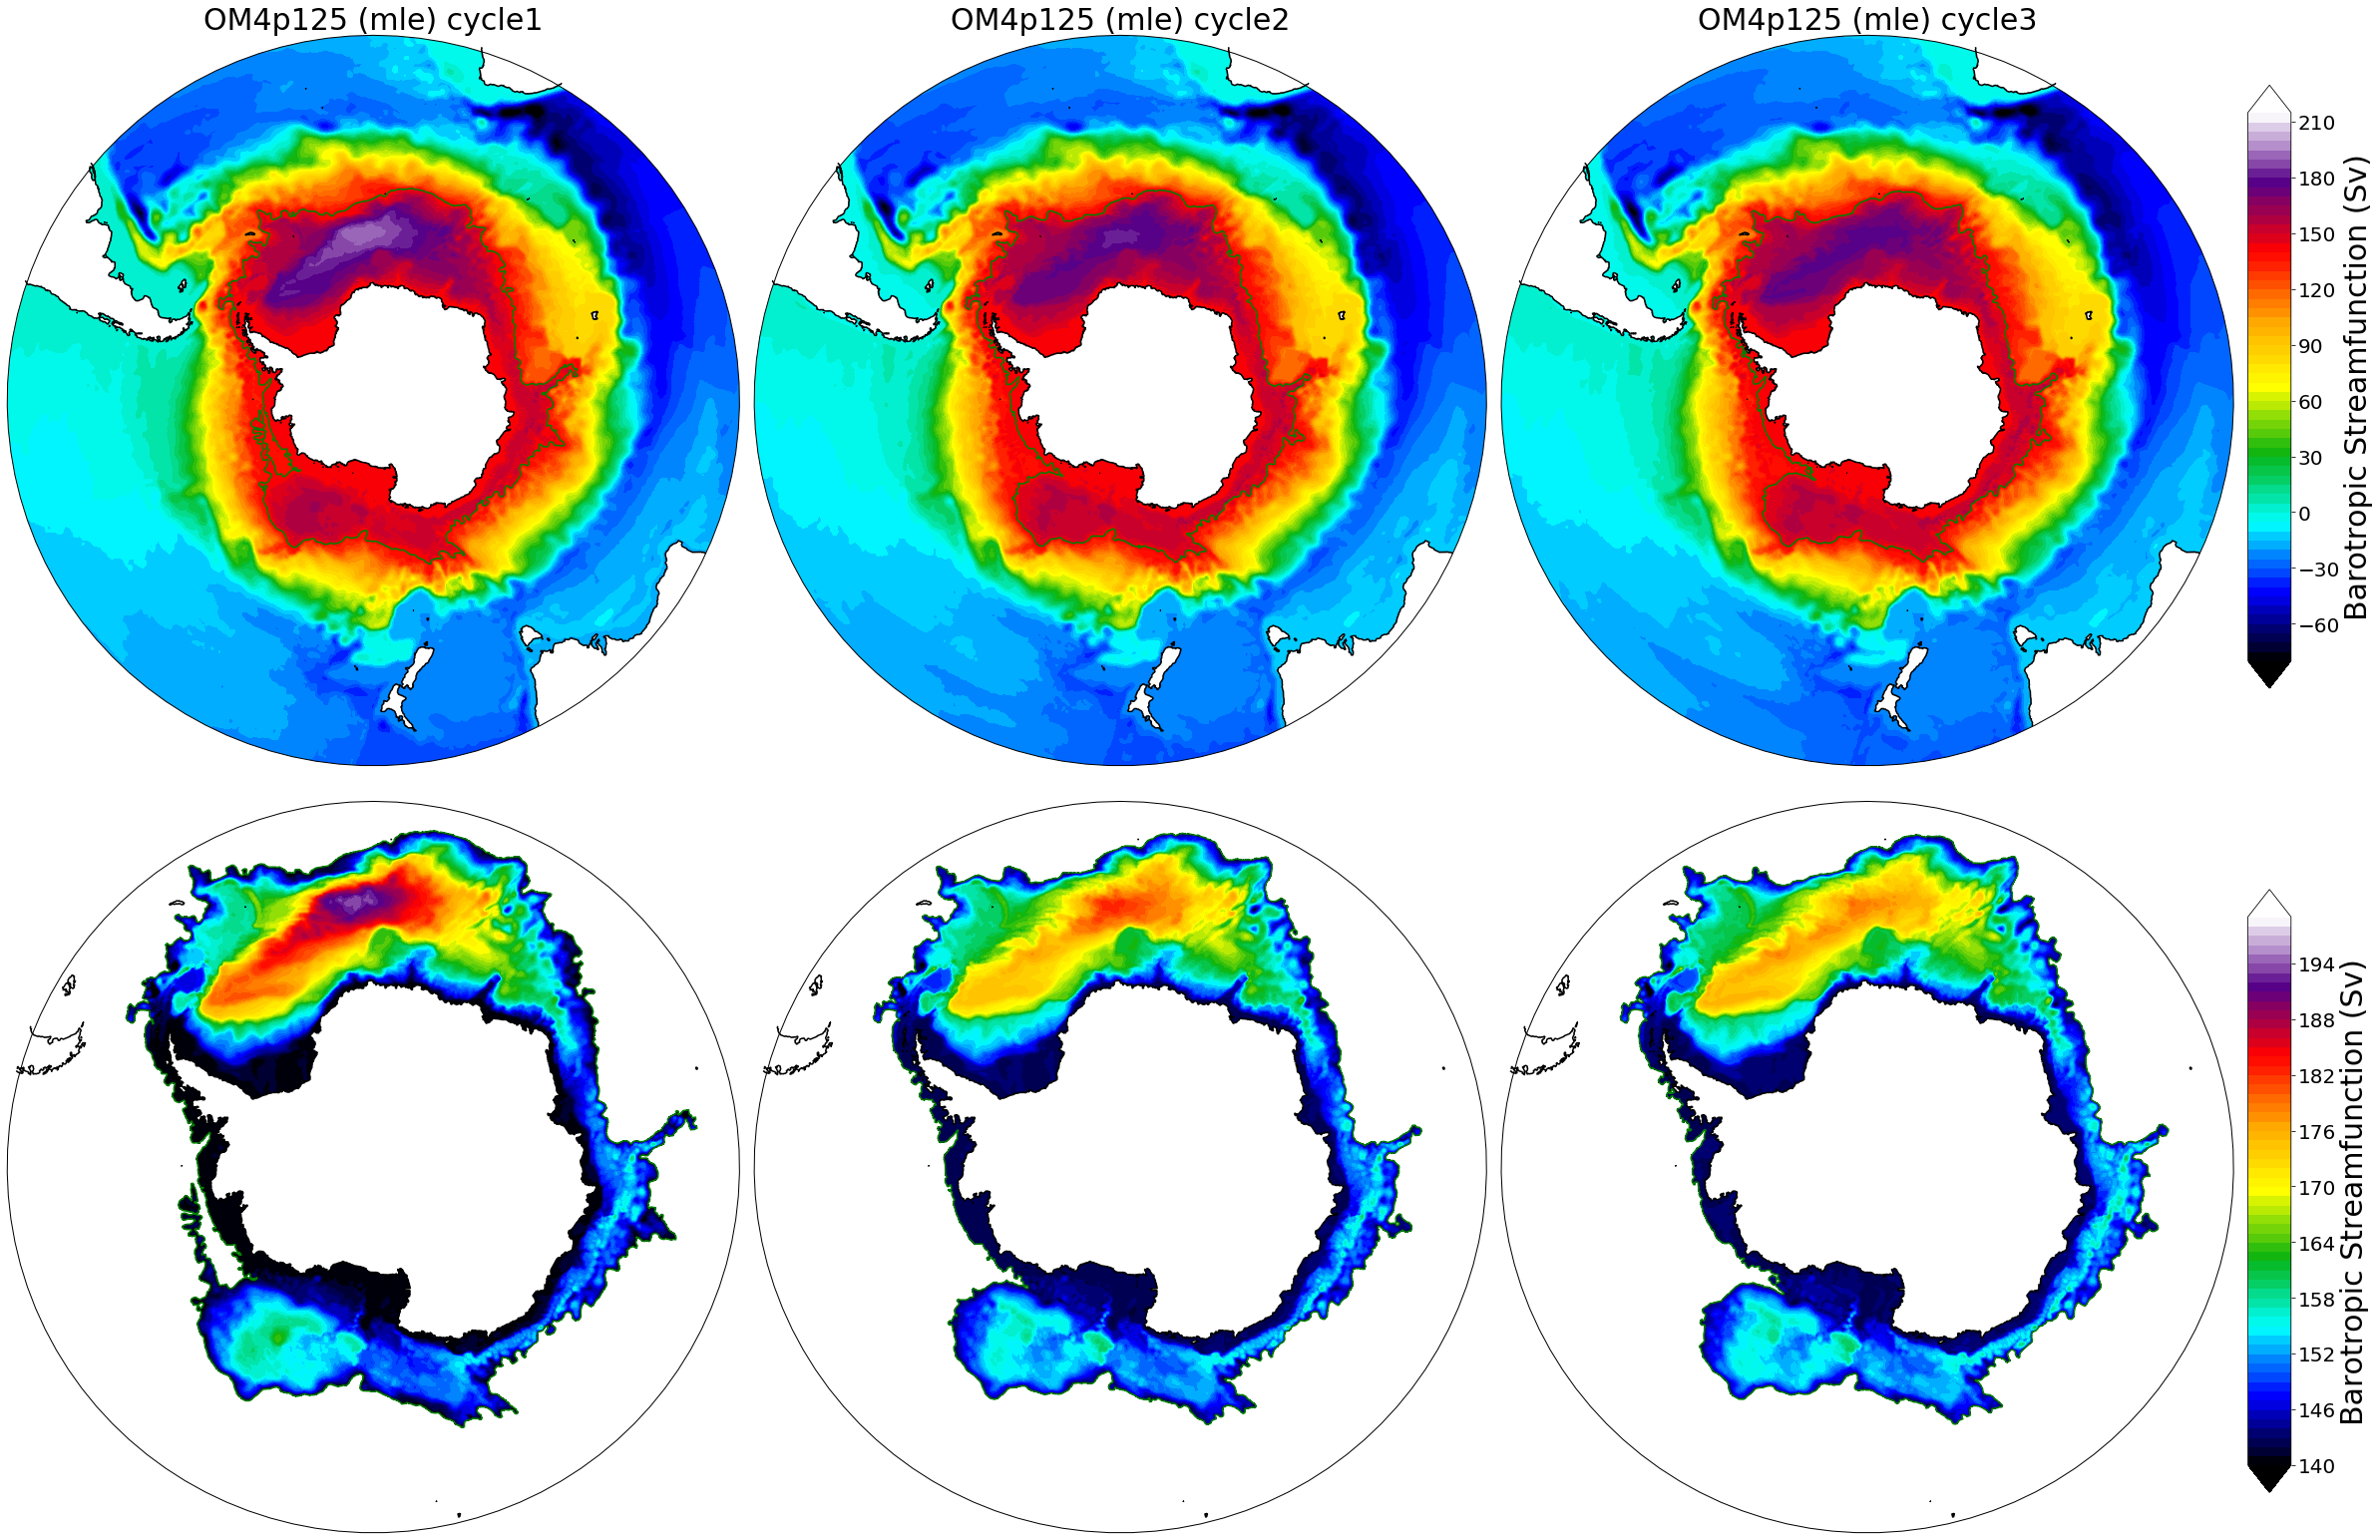

In [78]:
fig = plt.figure(figsize=[40, 28])
gs = gridspec.GridSpec(2,3)
proj = ccrs.Stereographic(central_longitude=0,central_latitude=-90)
ax,ax1,ax2 = plt.subplot(gs[0],projection = proj),plt.subplot(gs[1],projection = proj), plt.subplot(gs[2],projection = proj)
ax3,ax4,ax5 = plt.subplot(gs[3],projection = proj),plt.subplot(gs[4],projection = proj), plt.subplot(gs[5],projection = proj)
gs.update(wspace = 0.02, hspace = 0.02)
lat_north = -50

## p125 mle ##

land_mask =land_mask_125
geolon =geolon_125
geolat =geolat_125

lat_north = -30
so_basics(ax,land_mask,geolon, geolat, lat_north = lat_north, grid = False)
so_basics(ax1,land_mask,geolon, geolat, lat_north = lat_north, grid = False)
so_basics(ax2,land_mask,geolon, geolat, lat_north = lat_north, grid = False)
lat_north = -50
so_basics(ax3,land_mask,geolon, geolat, lat_north = lat_north, grid = False)
so_basics(ax4,land_mask,geolon, geolat, lat_north = lat_north, grid = False)
so_basics(ax5,land_mask,geolon, geolat, lat_north = lat_north, grid = False)

lvls = np.arange(-80, 220, 5)
cmap = nclcmaps.cmap('BkBlAqGrYeOrReViWh200')
cf = ax.contourf(geolon, geolat,p125_mle_SUCpsig_cycle1_psig*(land_mask.where(land_mask>0)), levels = lvls, cmap = cmap, extend = 'both', transform = ccrs.PlateCarree())
ax.contour(geolon,geolat,(p125_mle_SUCpsig_cycle1_mask*0).fillna(1), levels = [0,1], colors = 'g',alpha = 1,transform = ccrs.PlateCarree())
cf = ax1.contourf(geolon, geolat,p125_mle_SUCpsig_cycle2_psig*(land_mask.where(land_mask>0)), levels = lvls, cmap = cmap, extend = 'both', transform = ccrs.PlateCarree())
ax1.contour(geolon,geolat,(p125_mle_SUCpsig_cycle2_mask*0).fillna(1), levels = [0,1], colors = 'g',alpha = 1,transform = ccrs.PlateCarree())
cf = ax2.contourf(geolon, geolat,p125_mle_SUCpsig_cycle3_psig*(land_mask.where(land_mask>0)), levels = lvls, cmap = cmap, extend = 'both', transform = ccrs.PlateCarree())
ax2.contour(geolon,geolat,(p125_mle_SUCpsig_cycle3_mask*0).fillna(1), levels = [0,1], colors = 'g',alpha = 1,transform = ccrs.PlateCarree())
ax.set_title('OM4p125 (mle) cycle1', fontsize = 30)
ax1.set_title('OM4p125 (mle) cycle2', fontsize = 30)
ax2.set_title('OM4p125 (mle) cycle3', fontsize = 30)
cax = fig.add_axes([0.905, 0.55, 0.015, 0.3])
cbar=plt.colorbar(cf,cax = cax,orientation='vertical',shrink = 0.5)
cax.set_ylabel('Barotropic Streamfunction (Sv)', fontsize = 30)

lvls = np.arange(140, 200, 1)
cmap = nclcmaps.cmap('BkBlAqGrYeOrReViWh200')
plot = p125_mle_SUCpsig_cycle1_psig*(land_mask.where(land_mask>0))
plot = plot * p125_mle_SUCpsig_cycle1_mask.where(p125_mle_SUCpsig_cycle1_mask>0)
cf = ax3.contourf(geolon, geolat,plot, levels = lvls, cmap = cmap, extend = 'both', transform = ccrs.PlateCarree())
ax3.contour(geolon,geolat,(p125_mle_SUCpsig_cycle1_mask*0).fillna(1), levels = [0,1], colors = 'g',alpha = 1,transform = ccrs.PlateCarree())
plot = p125_mle_SUCpsig_cycle2_psig*(land_mask.where(land_mask>0))
plot = plot * p125_mle_SUCpsig_cycle2_mask.where(p125_mle_SUCpsig_cycle2_mask>0)
cf = ax4.contourf(geolon, geolat,plot, levels = lvls, cmap = cmap, extend = 'both', transform = ccrs.PlateCarree())
ax4.contour(geolon,geolat,(p125_mle_SUCpsig_cycle2_mask*0).fillna(1), levels = [0,1], colors = 'g',alpha = 1,transform = ccrs.PlateCarree())
plot = p125_mle_SUCpsig_cycle3_psig*(land_mask.where(land_mask>0))
plot = plot * p125_mle_SUCpsig_cycle3_mask.where(p125_mle_SUCpsig_cycle3_mask>0)
cf = ax5.contourf(geolon, geolat,plot, levels = lvls, cmap = cmap, extend = 'both', transform = ccrs.PlateCarree())
ax5.contour(geolon,geolat,(p125_mle_SUCpsig_cycle3_mask*0).fillna(1), levels = [0,1], colors = 'g',alpha = 1,transform = ccrs.PlateCarree())
cax = fig.add_axes([0.905, 0.15, 0.015, 0.3])
cbar=plt.colorbar(cf,cax = cax,orientation='vertical',shrink = 0.5)
cax.set_ylabel('Barotropic Streamfunction (Sv)', fontsize = 30)

figurepath = 'p125_mle_barotropic_streamfunction_SUC.png'
plt.savefig(figurepath, dpi=None, facecolor='w', edgecolor='w',orientation='portrait', papertype=None, format='png',transparent=False, bbox_inches='tight', pad_inches=0.15,frameon=None)

plt.show()

Zooming in on the Ross Gyre/ West Antarctic region

In [19]:
p125_SUCssh_cycle1 = xr.open_dataset('/work/Ruth.Moorman/masks_and_contours/OM4p125_IAF_csf_JRA55do1-3_r5/cycle1_1993-2017_mean_SUC-ssh.nc')
p125_SUCssh_cycle2 = xr.open_dataset('/work/Ruth.Moorman/masks_and_contours/OM4p125_IAF_csf_JRA55do1-3_r5/cycle2_1993-2017_mean_SUC-ssh.nc')
p125_SUCssh_cycle3 = xr.open_dataset('/work/Ruth.Moorman/masks_and_contours/OM4p125_IAF_csf_JRA55do1-3_r5/cycle3_1993-2017_mean_SUC-ssh.nc')
p125_mle_SUCssh_cycle1 = xr.open_dataset('/work/Ruth.Moorman/masks_and_contours/OM4p125_JRA55do1.4_mle3d/cycle1_1993-2017_mean_SUC-ssh.nc')
p125_mle_SUCssh_cycle2 = xr.open_dataset('/work/Ruth.Moorman/masks_and_contours/OM4p125_JRA55do1.4_mle3d/cycle2_1993-2017_mean_SUC-ssh.nc')
p125_mle_SUCssh_cycle3 = xr.open_dataset('/work/Ruth.Moorman/masks_and_contours/OM4p125_JRA55do1.4_mle3d/cycle3_1993-2017_mean_SUC-ssh.nc')
p25_SUCssh_cycle1 = xr.open_dataset('/work/Ruth.Moorman/masks_and_contours/OM4p25_IAF_BLING_CFC_csf_JRA55do1-3_r4r/cycle1_1993-2017_mean_SUC-ssh.nc')
p25_SUCssh_cycle2 = xr.open_dataset('/work/Ruth.Moorman/masks_and_contours/OM4p25_IAF_BLING_CFC_csf_JRA55do1-3_r4r/cycle2_1993-2017_mean_SUC-ssh.nc')
p25_SUCssh_cycle3 = xr.open_dataset('/work/Ruth.Moorman/masks_and_contours/OM4p25_IAF_BLING_CFC_csf_JRA55do1-3_r4r/cycle3_1993-2017_mean_SUC-ssh.nc')
p5_SUCssh_cycle1 = xr.open_dataset('/work/Ruth.Moorman/masks_and_contours/OM4p5_IAF_BLING_CFC_abio_csf_mle200_JRA55do1-3_r4r/cycle1_1993-2017_mean_SUC-ssh.nc')
p5_SUCssh_cycle2 = xr.open_dataset('/work/Ruth.Moorman/masks_and_contours/OM4p5_IAF_BLING_CFC_abio_csf_mle200_JRA55do1-3_r4r/cycle2_1993-2017_mean_SUC-ssh.nc')
p5_SUCssh_cycle3 = xr.open_dataset('/work/Ruth.Moorman/masks_and_contours/OM4p5_IAF_BLING_CFC_abio_csf_mle200_JRA55do1-3_r4r/cycle3_1993-2017_mean_SUC-ssh.nc')
p5_SUCssh_cycle4 = xr.open_dataset('/work/Ruth.Moorman/masks_and_contours/OM4p5_IAF_BLING_CFC_abio_csf_mle200_JRA55do1-3_r4r/cycle4_1993-2017_mean_SUC-ssh.nc')

In [21]:
p125_SUCssh_cycle1 = p125_SUCssh_cycle1.sel(yh = slice(-90,-29))
p125_SUCssh_cycle2 = p125_SUCssh_cycle2.sel(yh = slice(-90,-29))
p125_SUCssh_cycle3 = p125_SUCssh_cycle3.sel(yh = slice(-90,-29))
p125_mle_SUCssh_cycle1 = p125_mle_SUCssh_cycle1.sel(yh = slice(-90,-29))
p125_mle_SUCssh_cycle2 = p125_mle_SUCssh_cycle2.sel(yh = slice(-90,-29))
p125_mle_SUCssh_cycle3 = p125_mle_SUCssh_cycle3.sel(yh = slice(-90,-29))
p25_SUCssh_cycle1 = p25_SUCssh_cycle1.sel(yh = slice(-90,-29))
p25_SUCssh_cycle2 = p25_SUCssh_cycle2.sel(yh = slice(-90,-29))
p25_SUCssh_cycle3 = p25_SUCssh_cycle3.sel(yh = slice(-90,-29))
p5_SUCssh_cycle1 = p5_SUCssh_cycle1.sel(yh = slice(-90,-29))
p5_SUCssh_cycle2 = p5_SUCssh_cycle2.sel(yh = slice(-90,-29))
p5_SUCssh_cycle3 = p5_SUCssh_cycle3.sel(yh = slice(-90,-29))
p5_SUCssh_cycle4 = p5_SUCssh_cycle4.sel(yh = slice(-90,-29))

In [28]:
p125_SUCssh_cycle1.to_netcdf('/work/Ruth.Moorman/masks_and_contours/OM4p125_IAF_csf_JRA55do1-3_r5/cycle1_1993-2017_mean_SUC-ssh1.nc')
p125_SUCssh_cycle2.to_netcdf('/work/Ruth.Moorman/masks_and_contours/OM4p125_IAF_csf_JRA55do1-3_r5/cycle2_1993-2017_mean_SUC-ssh1.nc')
p125_SUCssh_cycle3.to_netcdf('/work/Ruth.Moorman/masks_and_contours/OM4p125_IAF_csf_JRA55do1-3_r5/cycle3_1993-2017_mean_SUC-ssh1.nc')
p125_mle_SUCssh_cycle1.to_netcdf('/work/Ruth.Moorman/masks_and_contours/OM4p125_JRA55do1.4_mle3d/cycle1_1993-2017_mean_SUC-ssh1.nc')
p125_mle_SUCssh_cycle2.to_netcdf('/work/Ruth.Moorman/masks_and_contours/OM4p125_JRA55do1.4_mle3d/cycle2_1993-2017_mean_SUC-ssh1.nc')
p125_mle_SUCssh_cycle3.to_netcdf('/work/Ruth.Moorman/masks_and_contours/OM4p125_JRA55do1.4_mle3d/cycle3_1993-2017_mean_SUC-ssh1.nc')
p25_SUCssh_cycle1.to_netcdf('/work/Ruth.Moorman/masks_and_contours/OM4p25_IAF_BLING_CFC_csf_JRA55do1-3_r4r/cycle1_1993-2017_mean_SUC-ssh1.nc')
p25_SUCssh_cycle2.to_netcdf('/work/Ruth.Moorman/masks_and_contours/OM4p25_IAF_BLING_CFC_csf_JRA55do1-3_r4r/cycle2_1993-2017_mean_SUC-ssh1.nc')
p25_SUCssh_cycle3.to_netcdf('/work/Ruth.Moorman/masks_and_contours/OM4p25_IAF_BLING_CFC_csf_JRA55do1-3_r4r/cycle3_1993-2017_mean_SUC-ssh1.nc')
p5_SUCssh_cycle1.to_netcdf('/work/Ruth.Moorman/masks_and_contours/OM4p5_IAF_BLING_CFC_abio_csf_mle200_JRA55do1-3_r4r/cycle1_1993-2017_mean_SUC-ssh1.nc')
p5_SUCssh_cycle2.to_netcdf('/work/Ruth.Moorman/masks_and_contours/OM4p5_IAF_BLING_CFC_abio_csf_mle200_JRA55do1-3_r4r/cycle2_1993-2017_mean_SUC-ssh1.nc')
p5_SUCssh_cycle3.to_netcdf('/work/Ruth.Moorman/masks_and_contours/OM4p5_IAF_BLING_CFC_abio_csf_mle200_JRA55do1-3_r4r/cycle3_1993-2017_mean_SUC-ssh1.nc')
p5_SUCssh_cycle4.to_netcdf('/work/Ruth.Moorman/masks_and_contours/OM4p5_IAF_BLING_CFC_abio_csf_mle200_JRA55do1-3_r4r/cycle4_1993-2017_mean_SUC-ssh1.nc')

In [35]:
p5_SUCssh_cycle1_mask = p5_SUCssh_cycle1.contour_masked_south
p5_SUCssh_cycle2_mask = p5_SUCssh_cycle2.contour_masked_south
p5_SUCssh_cycle3_mask = p5_SUCssh_cycle3.contour_masked_south
p5_SUCssh_cycle4_mask = p5_SUCssh_cycle4.contour_masked_south
p25_SUCssh_cycle1_mask = p25_SUCssh_cycle1.contour_masked_south
p25_SUCssh_cycle2_mask = p25_SUCssh_cycle2.contour_masked_south
p25_SUCssh_cycle3_mask = p25_SUCssh_cycle3.contour_masked_south
p125_SUCssh_cycle1_mask = p125_SUCssh_cycle1.contour_masked_south
p125_SUCssh_cycle2_mask = p125_SUCssh_cycle2.contour_masked_south
p125_SUCssh_cycle3_mask = p125_SUCssh_cycle3.contour_masked_south
p125_mle_SUCssh_cycle1_mask = p125_mle_SUCssh_cycle1.contour_masked_south
p125_mle_SUCssh_cycle2_mask = p125_mle_SUCssh_cycle2.contour_masked_south
p125_mle_SUCssh_cycle3_mask = p125_mle_SUCssh_cycle3.contour_masked_south

In [100]:
test = p125_SUCpsig_cycle1_psig-137.89

In [105]:
plot.min().values

array(-6.656082, dtype=float32)

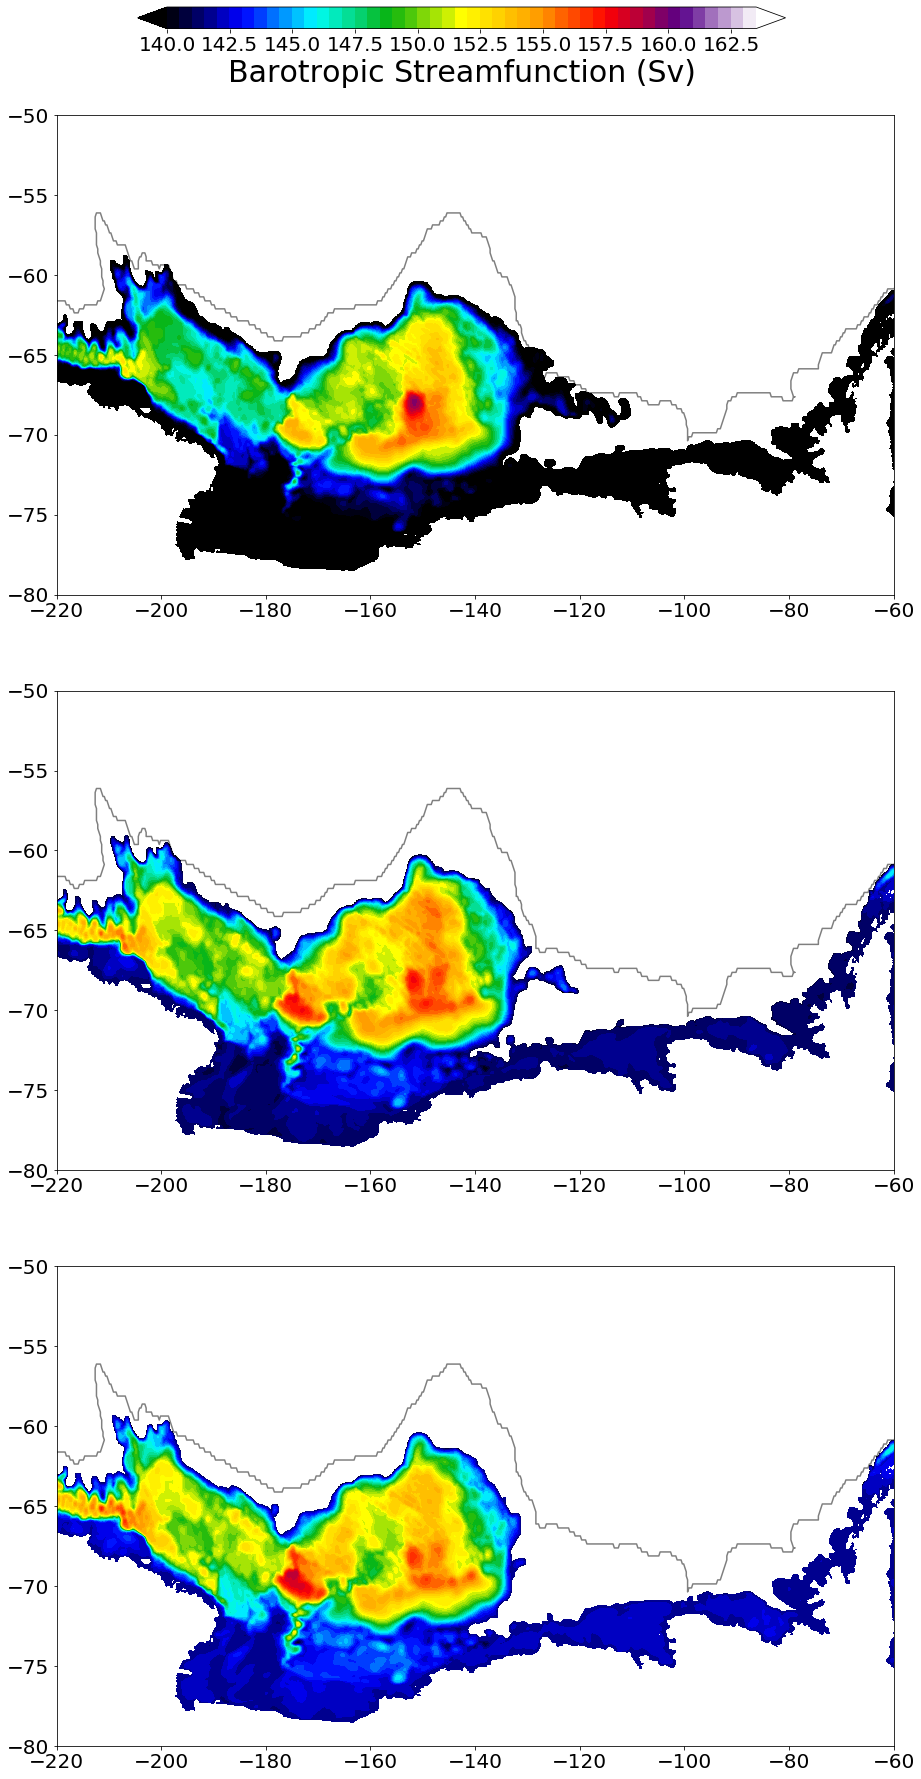

In [110]:
fig = plt.figure(figsize=[15, 30])
gs = gridspec.GridSpec(3,1)

ax, ax1, ax2= plt.subplot(gs[0]), plt.subplot(gs[1]), plt.subplot(gs[2])
lat_north = -50
geolon = geolon_125
geolat = geolat_125
land_mask = land_mask_125

lvls = np.arange(140, 164, 0.5)
cmap = nclcmaps.cmap('BkBlAqGrYeOrReViWh200')

plot = p125_SUCpsig_cycle1_psig*(land_mask.where(land_mask>0))
plot = plot * p125_SUCpsig_cycle1_mask.where(p125_SUCpsig_cycle1_mask>0)
cf = ax.contourf(geolon, geolat,plot, levels = lvls, cmap = cmap, extend = 'both')
# ax.contour(geolon,geolat,(p125_SUCssh_cycle1_mask*0).fillna(1), levels = [0,1], colors = 'k',alpha = 1)
ax.contour(cmems_SUCshh_mask.longitude-360, cmems_SUCshh_mask.latitude,cmems_SUCshh_mask.fillna(0), levels = [0,1], colors = 'k',alpha = 0.5)

plot = p125_SUCpsig_cycle2_psig*(land_mask.where(land_mask>0))
plot = plot * p125_SUCpsig_cycle2_mask.where(p125_SUCpsig_cycle2_mask>0)
cf = ax1.contourf(geolon, geolat,plot, levels = lvls, cmap = cmap, extend = 'both')
# ax1.contour(geolon,geolat,(p125_SUCssh_cycle2_mask*0).fillna(1), levels = [0,1], colors = 'k',alpha = 1)
ax1.contour(cmems_SUCshh_mask.longitude-360, cmems_SUCshh_mask.latitude,cmems_SUCshh_mask.fillna(0), levels = [0,1], colors = 'k',alpha = 0.5)

plot = p125_SUCpsig_cycle3_psig*(land_mask.where(land_mask>0))
plot = plot * p125_SUCpsig_cycle3_mask.where(p125_SUCpsig_cycle3_mask>0)
cf = ax2.contourf(geolon, geolat,plot, levels = lvls, cmap = cmap, extend = 'both')
# ax2.contour(geolon,geolat,(p125_SUCssh_cycle3_mask*0).fillna(1), levels = [0,1], colors = 'k',alpha = 1)
ax2.contour(cmems_SUCshh_mask.longitude-360, cmems_SUCshh_mask.latitude,cmems_SUCshh_mask.fillna(0), levels = [0,1], colors = 'k',alpha = 0.5)


ax.set_xlim([-220,-60])
ax.set_ylim([-80,-50])
ax1.set_xlim([-220,-60])
ax1.set_ylim([-80,-50])
ax2.set_xlim([-220,-60])
ax2.set_ylim([-80,-50])

cax = fig.add_axes([0.2, 0.92, 0.6, 0.01])
cbar=plt.colorbar(cf,cax = cax,orientation='horizontal',shrink = 0.5)
cax.set_xlabel('Barotropic Streamfunction (Sv)', fontsize = 30)
plt.show()

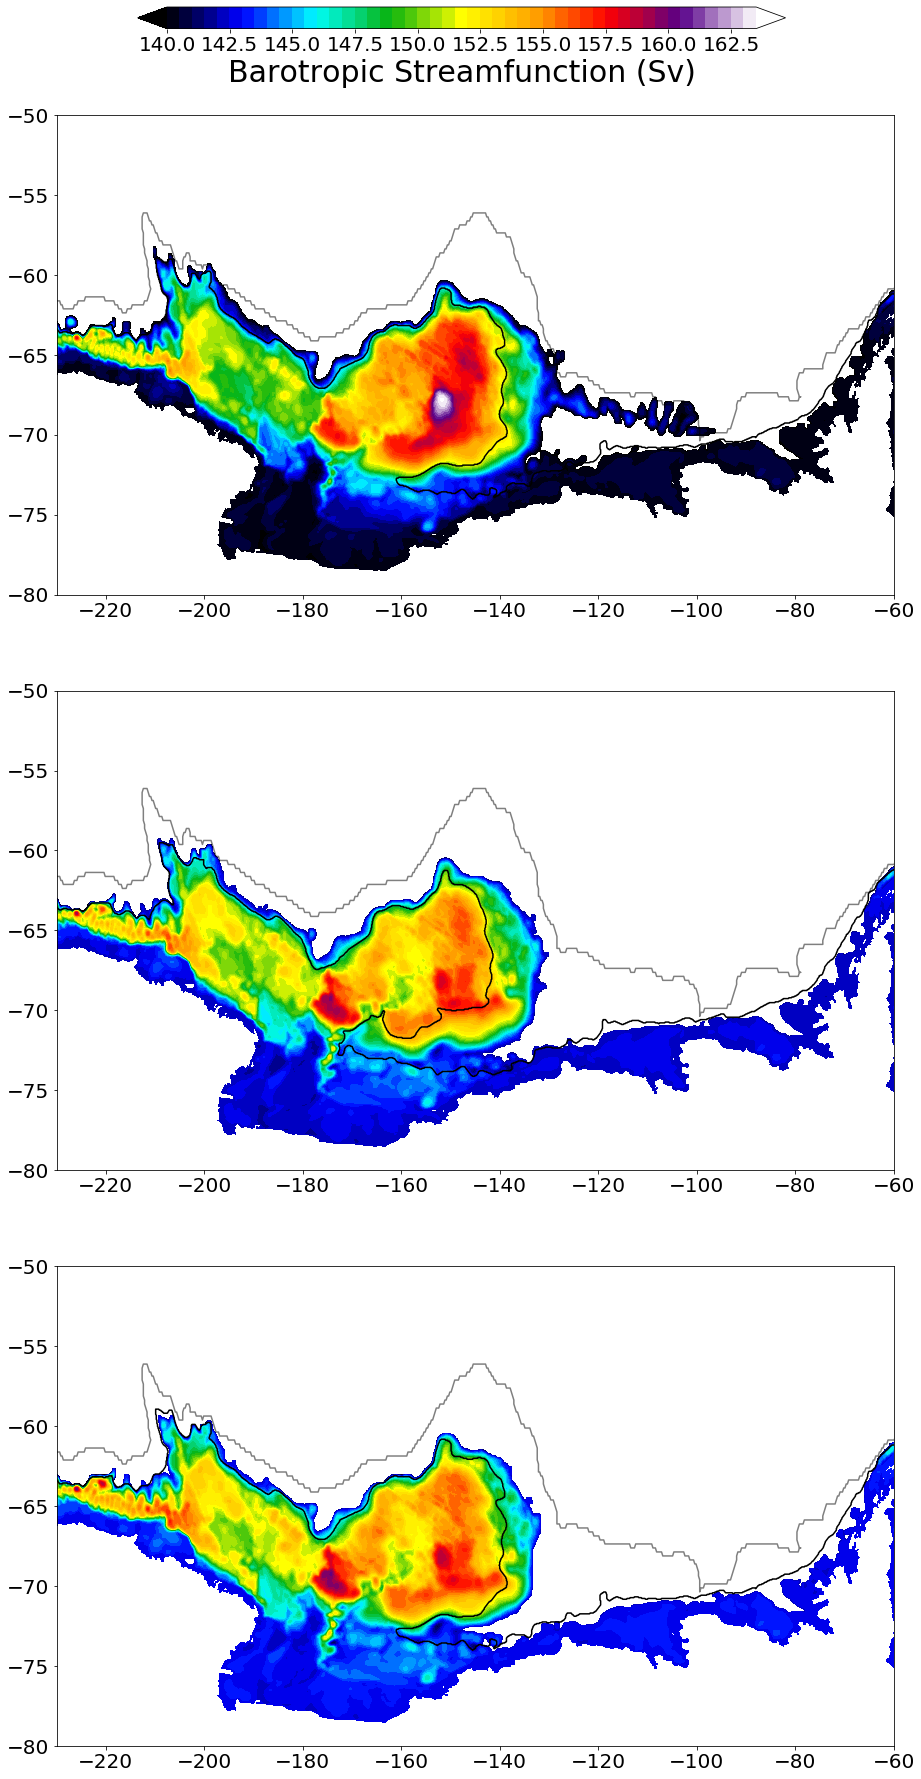

In [96]:
fig = plt.figure(figsize=[15, 30])
gs = gridspec.GridSpec(3,1)

ax, ax1, ax2= plt.subplot(gs[0]), plt.subplot(gs[1]), plt.subplot(gs[2])
lat_north = -50
geolon = geolon_125
geolat = geolat_125
land_mask = land_mask_125

lvls = np.arange(140, 164, 0.5)
cmap = nclcmaps.cmap('BkBlAqGrYeOrReViWh200')

plot = p125_mle_SUCpsig_cycle1_psig*(land_mask.where(land_mask>0))
plot = plot * p125_mle_SUCpsig_cycle1_mask.where(p125_mle_SUCpsig_cycle1_mask>0)
cf = ax.contourf(geolon, geolat,plot, levels = lvls, cmap = cmap, extend = 'both')
ax.contour(geolon,geolat,(p125_mle_SUCssh_cycle1_mask*0).fillna(1), levels = [0,1], colors = 'k',alpha = 1)
ax.contour(cmems_SUCshh_mask.longitude-360, cmems_SUCshh_mask.latitude,cmems_SUCshh_mask.fillna(0), levels = [0,1], colors = 'k',alpha = 0.5)

plot = p125_mle_SUCpsig_cycle2_psig*(land_mask.where(land_mask>0))
plot = plot * p125_mle_SUCpsig_cycle2_mask.where(p125_mle_SUCpsig_cycle2_mask>0)
cf = ax1.contourf(geolon, geolat,plot, levels = lvls, cmap = cmap, extend = 'both')
ax1.contour(geolon,geolat,(p125_mle_SUCssh_cycle2_mask*0).fillna(1), levels = [0,1], colors = 'k',alpha = 1)
ax1.contour(cmems_SUCshh_mask.longitude-360, cmems_SUCshh_mask.latitude,cmems_SUCshh_mask.fillna(0), levels = [0,1], colors = 'k',alpha = 0.5)

plot = p125_mle_SUCpsig_cycle3_psig*(land_mask.where(land_mask>0))
plot = plot * p125_mle_SUCpsig_cycle3_mask.where(p125_mle_SUCpsig_cycle3_mask>0)
cf = ax2.contourf(geolon, geolat,plot, levels = lvls, cmap = cmap, extend = 'both')
ax2.contour(geolon,geolat,(p125_mle_SUCssh_cycle3_mask*0).fillna(1), levels = [0,1], colors = 'k',alpha = 1)
ax2.contour(cmems_SUCshh_mask.longitude-360, cmems_SUCshh_mask.latitude,cmems_SUCshh_mask.fillna(0), levels = [0,1], colors = 'k',alpha = 0.5)


ax.set_xlim([-230,-60])
ax.set_ylim([-80,-50])
ax1.set_xlim([-230,-60])
ax1.set_ylim([-80,-50])
ax2.set_xlim([-230,-60])
ax2.set_ylim([-80,-50])

cax = fig.add_axes([0.2, 0.92, 0.6, 0.01])
cbar=plt.colorbar(cf,cax = cax,orientation='horizontal',shrink = 0.5)
cax.set_xlabel('Barotropic Streamfunction (Sv)', fontsize = 30)
plt.show()

## Defining the Ross Gyre extent
- largest enclosed contour that does not extend past -240º in the westward extent
- In the end, I don't think this is a super useful definition/metric, it's just too dependent on how far west you allow the Ross Gyre to be defined
- will keep this code in case it becomes useful later, it's still a good concept.

```
psig_db = p125_SUCpsig_cycle1
ACC_psig = np.ceil(psig_db.SUC_psig)
psig = psig_db.psig
lonstart = -160
latstart = -1 # if -1, start from northern bound, if 0 start from southern bound of gyre
cutoff_lon = -240

for contour in np.arange(ACC_psig,ACC_psig+100,1):
    temp = psig.where(psig<=contour) * 0 + 1
    temp_mask = psig.copy().fillna(1)
    xh = temp_mask.xq
    yh = temp_mask.yh
    temp_mask = temp_mask.where(temp_mask <= contour) * 0 + 1
    temp_mask = temp_mask.fillna(0)
    temp_mask = temp_mask.values # extract numpy fil
    kernel = np.ones((3,3),np.uint8)
    contour_mask0 = cv2.dilate(temp_mask,kernel,iterations=1) - temp_mask
    # start at western edge of domain, at y point closest to correct depth contour:
    contour_mask = np.zeros_like(temp_mask) 
    contour_lon_index_start = len(xh)-len(xh.where(xh>lonstart,drop = True))
    contour_lat_index_start = np.where(contour_mask0[:,contour_lon_index_start]>0)[0][latstart]
    contour_mask[contour_lat_index_start,contour_lon_index_start] = 1

    last_index_i = np.array([contour_lon_index_start])
    last_index_j = np.array([contour_lat_index_start])
    count = 0

    cutoff_index = len(xh)-len(xh.where(xh>cutoff_lon,drop = True))


    while last_index_i>cutoff_index:
        # first time don't go backwards:
        if last_index_i == 0:
            points_to_compare = np.array([contour_mask0[last_index_j,last_index_i+1],
                0,
                contour_mask0[last_index_j+1,last_index_i],
                contour_mask0[last_index_j-1,last_index_i]])
        else:
            points_to_compare = np.array([contour_mask0[last_index_j,last_index_i+1],
                contour_mask0[last_index_j,last_index_i-1],
                contour_mask0[last_index_j+1,last_index_i],
                contour_mask0[last_index_j-1,last_index_i]])
        new_loc = np.where(points_to_compare==1)[0]
        # this gives each point along contour a unique index number:
        if len(new_loc)==0:
            contour_mask0[last_index_j,last_index_i] = 0
            count = count - 1
            last_index_i = np.where(contour_mask==count+1)[1]
            last_index_j = np.where(contour_mask==count+1)[0]
    #         print(last_index_i)
            if len(last_index_i) != 1:
                last_index_i = np.array([last_index_i[0]])
                last_index_j = np.array([last_index_j[0]])
            else:
                continue
        elif len(new_loc)>0:
            if new_loc[0] == 0:
                new_index_i = last_index_i+1
                new_index_j = last_index_j
            elif new_loc[0] == 1:
                new_index_i = last_index_i-1
                new_index_j = last_index_j
            elif new_loc[0] == 2:
                new_index_i = last_index_i
                new_index_j = last_index_j+1
            elif new_loc[0] == 3:
                new_index_i = last_index_i
                new_index_j = last_index_j-1
            contour_mask[new_index_j,new_index_i] = count + 2
            contour_mask0[last_index_j,last_index_i] = 2
            last_index_j = new_index_j
            last_index_i = new_index_i
            count += 1
    #         print(last_index_i)
            if len(last_index_i) != 1:
                last_index_i = np.array([last_index_i[0]])
                last_index_j = np.array([last_index_j[0]])
    if contour_mask[:,cutoff_index+1].sum() == 0:
        a = np.where(contour_mask>0,1,0)
        b = a.sum(axis = 0)
        if np.count_nonzero(b ==1)<3:
            print('coarse gyre contour at %3.2f'%contour)
            coarse_result = contour
            break


    ## refined loop
for contour in np.arange(coarse_result-1,coarse_result,0.1):
    temp = psig.where(psig<=contour) * 0 + 1
    temp_mask = psig.copy().fillna(1)
    xh = temp_mask.xq
    yh = temp_mask.yh
    temp_mask = temp_mask.where(temp_mask <= contour) * 0 + 1
    temp_mask = temp_mask.fillna(0)
    temp_mask = temp_mask.values # extract numpy fil
    kernel = np.ones((3,3),np.uint8)
    contour_mask0 = cv2.dilate(temp_mask,kernel,iterations=1) - temp_mask
    # start at western edge of domain, at y point closest to correct depth contour:
    contour_mask = np.zeros_like(temp_mask) 
    contour_lon_index_start = len(xh)-len(xh.where(xh>lonstart,drop = True))
    contour_lat_index_start = np.where(contour_mask0[:,contour_lon_index_start]>0)[0][latstart]
    contour_mask[contour_lat_index_start,contour_lon_index_start] = 1

    last_index_i = np.array([contour_lon_index_start])
    last_index_j = np.array([contour_lat_index_start])
    count = 0

    cutoff_index = len(xh)-len(xh.where(xh>cutoff_lon,drop = True))


    while last_index_i>cutoff_index:
        # first time don't go backwards:
        if last_index_i == 0:
            points_to_compare = np.array([contour_mask0[last_index_j,last_index_i+1],
                0,
                contour_mask0[last_index_j+1,last_index_i],
                contour_mask0[last_index_j-1,last_index_i]])
        else:
            points_to_compare = np.array([contour_mask0[last_index_j,last_index_i+1],
                contour_mask0[last_index_j,last_index_i-1],
                contour_mask0[last_index_j+1,last_index_i],
                contour_mask0[last_index_j-1,last_index_i]])
        new_loc = np.where(points_to_compare==1)[0]
        # this gives each point along contour a unique index number:
        if len(new_loc)==0:
            contour_mask0[last_index_j,last_index_i] = 0
            count = count - 1
            last_index_i = np.where(contour_mask==count+1)[1]
            last_index_j = np.where(contour_mask==count+1)[0]
    #         print(last_index_i)
            if len(last_index_i) != 1:
                last_index_i = np.array([last_index_i[0]])
                last_index_j = np.array([last_index_j[0]])
            else:
                continue
        elif len(new_loc)>0:
            if new_loc[0] == 0:
                new_index_i = last_index_i+1
                new_index_j = last_index_j
            elif new_loc[0] == 1:
                new_index_i = last_index_i-1
                new_index_j = last_index_j
            elif new_loc[0] == 2:
                new_index_i = last_index_i
                new_index_j = last_index_j+1
            elif new_loc[0] == 3:
                new_index_i = last_index_i
                new_index_j = last_index_j-1
            contour_mask[new_index_j,new_index_i] = count + 2
            contour_mask0[last_index_j,last_index_i] = 2
            last_index_j = new_index_j
            last_index_i = new_index_i
            count += 1
    #         print(last_index_i)

            if len(last_index_i) != 1:
                last_index_i = np.array([last_index_i[0]])
                last_index_j = np.array([last_index_j[0]])
    if contour_mask[:,cutoff_index+1].sum() == 0:
        a = np.where(contour_mask>0,1,0)
        b = a.sum(axis = 0)
        if np.count_nonzero(b ==1)<3:
            print('refined gyre contour at %3.2f'%contour)
            coarse_result = contour
            break
    
contour_mask_numbered = contour_mask

fig = plt.figure(figsize=[15, 10])
ax= plt.subplot()
lat_north = -50
geolon = geolon_125
geolat = geolat_125
land_mask = land_mask_125

ax.contour(temp.xq, temp.yh,contour_mask0, levels = [-1,0,1], colors = 'b',alpha = 0.5)
ax.contour(temp.xq, temp.yh,contour_mask, levels = [0,1], colors = 'r',alpha = 0.5)
ax.plot(temp.xq[contour_lon_index_start], temp.yh[contour_lat_index_start],'ko', markersize = 10)
ax.plot(temp.xq[last_index_i], temp.yh[last_index_j],'go', markersize = 10)


plt.show()
```

## New variability idea
Instead of looking at the variability of the area of the Ross GYre directly, with all it's complexities and difficulties associated with definiting that extent (attempt above) I think I will look at the variabiity of the area bound by the SUC of barotrpic streamfunction. Circumpolar sum but also, probably more importantly, sector sums isolating the Ross, Weddell, and Kerguelen gyre regions. 

To look at variability, I will need to generate SUC-psig information at a greater temporal resolution. Instinct is monthly, since we will anticipate a seasonal cycle in convective processes.

In [21]:
#monthly data p5
p5_umo_2D_C1 = xr.open_mfdataset('/archive/oar.gfdl.ogrp-account/CMIP6/OMIP/xanadu_mom6_20181101/OM4p5_IAF_BLING_CFC_abio_csf_mle200_JRA55do1-3_r4r_cycle1/gfdl.ncrc4-intel16f2-prod/pp/ocean_monthly/ts/monthly/20yr/ocean_monthly.*.umo_2d.nc')
p5_umo_2D_C2 = xr.open_mfdataset('/archive/oar.gfdl.ogrp-account/CMIP6/OMIP/xanadu_mom6_20181101/OM4p5_IAF_BLING_CFC_abio_csf_mle200_JRA55do1-3_r4r_cycle2/gfdl.ncrc4-intel16f2-prod/pp/ocean_monthly/ts/monthly/20yr/ocean_monthly.*.umo_2d.nc')
p5_umo_2D_C3 = xr.open_mfdataset('/archive/oar.gfdl.ogrp-account/CMIP6/OMIP/xanadu_mom6_20181101/OM4p5_IAF_BLING_CFC_abio_csf_mle200_JRA55do1-3_r4r_cycle3/gfdl.ncrc4-intel16f2-prod/pp/ocean_monthly/ts/monthly/20yr/ocean_monthly.*.umo_2d.nc')
p5_umo_2D_C1 = p5_umo_2D_C1.umo_2d.sel(yh = slice(-90,-29))
p5_umo_2D_C2 = p5_umo_2D_C2.umo_2d.sel(yh = slice(-90,-29))
p5_umo_2D_C3 = p5_umo_2D_C3.umo_2d.sel(yh = slice(-90,-29))

In [7]:
def OM4_ACCS_psig_contour(umo_2D,land_mask,lat_north = -29):
    ρ = 1036 # kg/m^3
    psi = -umo_2D.cumsum('yh')/(1e6*ρ) # divide by 1e6 to convert m^3/s
    psi_acc = np.nanmin(psi.sel(xq = slice(-69, -67), yh = slice(-80, -55)))
#     print('Max value of streamfunction south of 55S and within 69W-67W (ACC transport) = ', -psi_acc, 'Sv')
    psi_g = psi-psi_acc
    
    adjust = 0
    for k in range(10):
        
        contour = -psi_acc-(adjust * 0.1)
        temp = psi_g.where(psi_g>=contour) * 0 + 1
        temp_mask = psi_g.copy().fillna(1)
        xh = temp_mask.xq
        yh = temp_mask.yh
        temp_mask = temp_mask.where(temp_mask >= contour) * 0 + 1
        temp_mask = temp_mask.fillna(0)
        temp_mask = temp_mask.values # extract numpy file
        # # this spreads the isobath contour so all points are connected adjacently (not just 
        # # diagonally):

        kernel = np.ones((3,3),np.uint8)
        contour_mask0 = cv2.dilate(temp_mask,kernel,iterations=1) - temp_mask
        # start at western edge of domain, at y point closest to correct depth contour:
        contour_mask = np.zeros_like(temp_mask) 
        contour_lat_index_start = np.where(contour_mask0[:,0]>0)[0][-1]
        contour_mask[contour_lat_index_start,0] = 1
        # loop through to find adjacent point closest to contour depth (not inc previous point):
        last_index_i = np.array([0])
        last_index_j = contour_lat_index_start
        count = np.array([0])


        while last_index_i<(len(xh)-1): # 1440 is xh dimension length
            # first time don't go backwards:
            if last_index_i == 0:
                points_to_compare = np.array([contour_mask0[last_index_j,last_index_i+1],
                    0,
                    contour_mask0[last_index_j+1,last_index_i],
                    contour_mask0[last_index_j-1,last_index_i]])
            else:
                points_to_compare = np.array([contour_mask0[last_index_j,last_index_i+1],
                    contour_mask0[last_index_j,last_index_i-1],
                    contour_mask0[last_index_j+1,last_index_i],
                    contour_mask0[last_index_j-1,last_index_i]])
            new_loc = np.where(points_to_compare==1)[0]
            # this gives each point along contour a unique index number:
            if len(new_loc)==0:
                contour_mask0[last_index_j,last_index_i] = 0
                count = count - 1
                last_index_i = np.where(contour_mask==count+1)[1]
                last_index_j = np.where(contour_mask==count+1)[0]
                if len(last_index_i)>1:
                    last_index_i = last_index_i[0]
                    last_index_j = last_index_j[0]
                else:
                    continue
            elif len(new_loc)>0:
                if new_loc[0] == 0:
                    new_index_i = last_index_i+1
                    new_index_j = last_index_j
                elif new_loc[0] == 1:
                    new_index_i = last_index_i-1
                    new_index_j = last_index_j
                elif new_loc[0] == 2:
                    new_index_i = last_index_i
                    new_index_j = last_index_j+1            
                elif new_loc[0] == 3:
                    new_index_i = last_index_i
                    new_index_j = last_index_j-1

                contour_mask[new_index_j,new_index_i] = count + 2
                contour_mask0[last_index_j,last_index_i] = 2
                last_index_j = new_index_j
                last_index_i = new_index_i
                count += 1
                if len(np.array([last_index_i])) >1:
                    last_index_i = last_index_i[0]
                    last_index_j = last_index_j[0]
        
        if (contour_mask * land_mask).sum(dim = 'yh'). min(dim = 'xq') == 1:
            # sometimes the contour fitting algorithm falls onto the land mask edge and stays there, erroneously resulting in a circumpolar continuous contour. Add the constraint that the final index does not coincide with land (seems to be enough).
#             print('adjusted:',adjust)
            break
        else:
            adjust += 1 
    # # this is the sequentially numbered isobath, it provides an along isobath index
#     print(adjust)
    contour_mask_numbered = contour_mask
    # sometimes there's a discontinuoity at 0
    if last_index_j > contour_lat_index_start:
        a = 0
        for m in np.arange(last_index_j,contour_lat_index_start-1, -1):
            contour_mask_numbered[m,-1] = contour_mask_numbered[last_index_j,-1] +a
            a += 1
    elif last_index_j < contour_lat_index_start:
        a = 0
        for m in np.arange(last_index_j, contour_lat_index_start+1, 1):
            contour_mask_numbered[m,-1] = contour_mask_numbered[last_index_j,-1] +a
            a += 1
    # fill in points to north of contour:
    contour_masked_above = np.copy(contour_mask_numbered)
    contour_masked_above[-1,0] = -100

    # from top left:
    for ii in range(len(xh)-1):
        for jj in range(len(yh))[::-1][:-1]:
            if contour_masked_above[jj,ii] == -100:
                if contour_masked_above[jj-1,ii] == 0:
                    contour_masked_above[jj-1,ii] = -100
                if contour_masked_above[jj,ii+1] == 0:
                    contour_masked_above[jj,ii+1] = -100
                if contour_masked_above[jj-1,ii+1] == 0:
                    contour_masked_above[jj-1,ii+1] = -100
    # from top right:
    for ii in range(len(xh))[::-1][:-1]:
        for jj in range(len(yh))[::-1][:-1]:
            if contour_masked_above[jj,ii] == -100:
                if contour_masked_above[jj-1,ii] == 0:
                    contour_masked_above[jj-1,ii] = -100
                if contour_masked_above[jj,ii-1] == 0:
                    contour_masked_above[jj,ii-1] = -100
                if contour_masked_above[jj-1,ii-1] == 0:
                    contour_masked_above[jj-1,ii-1] = -100
    # from bottom right:
    for ii in range(len(xh))[::-1][:-1]:
        for jj in range(len(yh)-1):
            if contour_masked_above[jj,ii] == -100:
                if contour_masked_above[jj+1,ii] == 0:
                    contour_masked_above[jj+1,ii] = -100
                if contour_masked_above[jj,ii-1] == 0:
                    contour_masked_above[jj,ii-1] = -100
                if contour_masked_above[jj+1,ii-1] == 0:
                    contour_masked_above[jj+1,ii-1] = -100
    # from bottom left:
    for ii in range(len(xh)-1):
        for jj in range(len(yh)-1):
            if contour_masked_above[jj,ii] == -100:
                if contour_masked_above[jj+1,ii] == 0:
                    contour_masked_above[jj+1,ii] = -100
                if contour_masked_above[jj,ii+1] == 0:
                    contour_masked_above[jj,ii+1] = -100
                if contour_masked_above[jj+1,ii+1] == 0:
                    contour_masked_above[jj+1,ii+1] = -100
    contour_masked_south = xr.DataArray(contour_masked_above, coords = [yh, xh], dims = ['yh', 'xq'])
    contour_mask_numbered = xr.DataArray(contour_mask_numbered, coords = [yh, xh], dims = ['yh', 'xq'])
    contour_masked_south = contour_masked_south.where(contour_masked_south >= 0) * 0 + 1 
    
    return contour_masked_south,contour_mask_numbered,psi_g,contour, temp_mask

In [66]:
# want to save all as one file, one cycle after the other.
# will set it so that the final cycle has the original time dimension, and preceding cycles are staggered back
cycletime = np.arange('1838-01','2018-01', dtype='datetime64[M]')
p5_psig_array = xr.DataArray(np.empty((2160,181,720)), coords = [cycletime, p5_umo_2D_C1.yh, p5_umo_2D_C1.xq], dims = ['time', 'yh', 'xq'])
p5_psig_array[:,:,:] = np.nan
p5_psig_array.attrs['long_name'] = 'Barotropic Steamfunction'
p5_psig_array.attrs['units'] = 'Sv'
p5_SUCpsig_mask_array = xr.DataArray(np.empty((2160,181,720)), coords = [cycletime, p5_umo_2D_C1.yh, p5_umo_2D_C1.xq], dims = ['time', 'yh', 'xq'])
p5_SUCpsig_mask_array[:,:,:] = np.nan
p5_SUCpsig_mask_array.attrs['description'] = 'masks for the region south of the southernmost unblocked contour of the monthly mean barotropic streamfunction'
p5_SUCpsig_array = xr.DataArray(np.empty((2160)), coords = [cycletime], dims = ['time'])
p5_SUCpsig_array[:] = np.nan
p5_SUCpsig_array.attrs['description'] = 'value for the southermost unblocked contour of the monthly mean barotropic streamfunction (also the ACC transport)'

In [68]:
%%time
# first cycle
for i in range(720):
    contour_masked_south,psi_g,contour= OM4_ACCS_psig_contour(p5_umo_2D_C1.isel(time = i))
    p5_psig_array[i,:,:] = psi_g.values
    p5_SUCpsig_mask_array[i,:,:] = contour_masked_south.values
    p5_SUCpsig_array[i] = contour

CPU times: user 35min 34s, sys: 7.92 s, total: 35min 42s
Wall time: 35min 51s


In [75]:
%%time
# second cycle
for i in range(720):
    contour_masked_south,psi_g,contour= OM4_ACCS_psig_contour(p5_umo_2D_C2.isel(time = i))
    p5_psig_array[720+i,:,:] = psi_g.values
    p5_SUCpsig_mask_array[720+i,:,:] = contour_masked_south.values
    p5_SUCpsig_array[720+i] = contour

CPU times: user 35min 44s, sys: 7.7 s, total: 35min 52s
Wall time: 36min


In [76]:
%%time
# third cycle
for i in range(720):
    contour_masked_south,psi_g,contour= OM4_ACCS_psig_contour(p5_umo_2D_C3.isel(time = i))
    p5_psig_array[1440+i,:,:] = psi_g.values
    p5_SUCpsig_mask_array[1440+i,:,:] = contour_masked_south.values
    p5_SUCpsig_array[1440+i] = contour

CPU times: user 35min 30s, sys: 7.98 s, total: 35min 38s
Wall time: 35min 43s


In [77]:
p5_psig_array.coords['SUC_psig'] = p5_SUCpsig_array
p5_psig_array.coords['geolon'] = geolon_5
p5_psig_array.coords['geolat'] = geolat_5

p5_SUCpsig_mask_array.coords['SUC_psig'] = p5_SUCpsig_array
p5_SUCpsig_mask_array.coords['geolon'] = geolon_5
p5_SUCpsig_mask_array.coords['geolat'] = geolat_5

In [78]:
ds = xr.Dataset({'SUC_psig_mask':p5_SUCpsig_mask_array, 'psig':p5_psig_array})
ds.to_netcdf('/work/Ruth.Moorman/masks_and_contours/OM4p5_IAF_BLING_CFC_abio_csf_mle200_JRA55do1-3_r4r/monthly_SUC_psig.nc')

In the context of this variability analysis, the regiorous contour fitting script is not very convenient and is likely unecessary. I will instead take a simple mask based on the ACC psi contour that comes out of the normalisation.

In [8]:
p25_umo_2d_C1 = xr.open_dataset('/archive/Ruth.Moorman/OM4p25_IAF_BLING_CFC_csf_JRA55do1-3_r4r/cycle1/ocean_month/ocean_month.umo_2d.nc')
p25_umo_2d_C2 = xr.open_dataset('/archive/Ruth.Moorman/OM4p25_IAF_BLING_CFC_csf_JRA55do1-3_r4r/cycle2/ocean_month/ocean_month.umo_2d.nc')
p25_umo_2d_C3 = xr.open_dataset('/archive/Ruth.Moorman/OM4p25_IAF_BLING_CFC_csf_JRA55do1-3_r4r/cycle3/ocean_month/ocean_month.umo_2d.nc')

In [9]:
p25_umo_2d_C1 = p25_umo_2d_C1.umo_2d.sel(yh = slice(-90,-29))
p25_umo_2d_C2 = p25_umo_2d_C2.umo_2d.sel(yh = slice(-90,-29))
p25_umo_2d_C3 = p25_umo_2d_C3.umo_2d.sel(yh = slice(-90,-29))

In [10]:
cycletime = np.arange('1838-01','2018-01', dtype='datetime64[M]')


In [ ]:
# want to save all as one file, one cycle after the other.
# will set it so that the final cycle has the original time dimension, and preceding cycles are staggered back
p25_psig_array = xr.DataArray(np.empty((720,382,1440)), coords = [cycletime[:720], p25_umo_2d_C1.yh, p25_umo_2d_C1.xq], dims = ['time', 'yh', 'xq'])
p25_psig_array[:,:,:] = np.nan
p25_psig_array.attrs['long_name'] = 'Barotropic Steamfunction'
p25_psig_array.attrs['units'] = 'Sv'
p25_SUCpsig_mask_array = xr.DataArray(np.empty((720,382,1440)), coords = [cycletime[:720], p25_umo_2d_C1.yh, p25_umo_2d_C1.xq], dims = ['time', 'yh', 'xq'])
p25_SUCpsig_mask_array[:,:,:] = np.nan
p25_SUCpsig_mask_array.attrs['description'] = 'masks for the region south of the southernmost unblocked contour of the monthly mean barotropic streamfunction'
p25_SUCpsig_numbered_array = xr.DataArray(np.empty((720,382,1440)), coords = [cycletime[:720], p25_umo_2d_C1.yh, p25_umo_2d_C1.xq], dims = ['time', 'yh', 'xq'])
p25_SUCpsig_numbered_array[:,:,:] = np.nan
p25_SUCpsig_numbered_array.attrs['description'] = 'numbered index along the southernmost unblocked contour of the monthly mean barotropic streamfunction'
p25_SUCpsig_array = xr.DataArray(np.empty((720)), coords = [cycletime[:720]], dims = ['time'])
p25_SUCpsig_array[:] = np.nan
p25_SUCpsig_array.attrs['description'] = 'value for the southermost unblocked contour of the monthly mean barotropic streamfunction (also the ACC transport)'

In [ ]:
%%time
# first cycle
for i in range(720):
    contour_masked_south,contour_mask_numbered,psi_g,contour, _= OM4_ACCS_psig_contour(p25_umo_2d_C1.isel(time = i), land_mask_25)
    p25_psig_array[i,:,:] = psi_g.values
    p25_SUCpsig_mask_array[i,:,:] = contour_masked_south.values
    p25_SUCpsig_numbered_array[i,:,:] = contour_mask_numbered.values
    p25_SUCpsig_array[i] = contour
    if i in {100,200, 300, 400, 500}:
        print(i)

In [ ]:
ds = xr.Dataset({'SUC_psig_mask':p25_SUCpsig_mask_array, 'SUC_psig_numbered':p25_SUCpsig_numbered_array,'psig':p25_psig_array})
ds.to_netcdf('/work/Ruth.Moorman/masks_and_contours/OM4p25_IAF_BLING_CFC_csf_JRA55do1-3_r4r/monthly_SUC_psig_C1.nc')

In [11]:
p25_psig_array = xr.DataArray(np.empty((720,382,1440)), coords = [cycletime[720:1440], p25_umo_2d_C1.yh, p25_umo_2d_C1.xq], dims = ['time', 'yh', 'xq'])
p25_psig_array[:,:,:] = np.nan
p25_psig_array.attrs['long_name'] = 'Barotropic Steamfunction'
p25_psig_array.attrs['units'] = 'Sv'
p25_SUCpsig_mask_array = xr.DataArray(np.empty((720,382,1440)), coords = [cycletime[720:1440], p25_umo_2d_C1.yh, p25_umo_2d_C1.xq], dims = ['time', 'yh', 'xq'])
p25_SUCpsig_mask_array[:,:,:] = np.nan
p25_SUCpsig_mask_array.attrs['description'] = 'masks for the region south of the southernmost unblocked contour of the monthly mean barotropic streamfunction'
p25_SUCpsig_numbered_array = xr.DataArray(np.empty((720,382,1440)), coords = [cycletime[720:1440], p25_umo_2d_C1.yh, p25_umo_2d_C1.xq], dims = ['time', 'yh', 'xq'])
p25_SUCpsig_numbered_array[:,:,:] = np.nan
p25_SUCpsig_numbered_array.attrs['description'] = 'numbered index along the southernmost unblocked contour of the monthly mean barotropic streamfunction'
p25_SUCpsig_array = xr.DataArray(np.empty((720)), coords = [cycletime[720:1440]], dims = ['time'])
p25_SUCpsig_array[:] = np.nan
p25_SUCpsig_array.attrs['description'] = 'value for the southermost unblocked contour of the monthly mean barotropic streamfunction (also the ACC transport)'

In [12]:
%%time
# second cycle
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Time (start) =", current_time)
for i in range(720):
    contour_masked_south,contour_mask_numbered,psi_g,contour, _= OM4_ACCS_psig_contour(p25_umo_2d_C2.isel(time = i), land_mask_25.sel(yh = slice(-90,-29)))
    p25_psig_array[i,:,:] = psi_g.values
    p25_SUCpsig_mask_array[i,:,:] = contour_masked_south.values
    p25_SUCpsig_numbered_array[i,:,:] = contour_mask_numbered.values
    p25_SUCpsig_array[i] = contour
    if i in {100,200, 300, 400, 500,600,700}:
        print(i)
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Time =", current_time)
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Time (done) =", current_time)

Time (start) = 10:33:11
100
Time = 11:01:06
200
Time = 11:26:14
300
Time = 11:56:47
400
Time = 12:24:04
500
Time = 12:51:11
600
Time = 13:19:47
700
Time = 13:49:11
Time (done) = 13:55:17
CPU times: user 3h 21min 20s, sys: 4.67 s, total: 3h 21min 24s
Wall time: 3h 22min 6s


In [13]:
p25_psig_array.coords['SUC_psig'] = p25_SUCpsig_array
p25_psig_array.coords['geolon'] = geolon_25
p25_psig_array.coords['geolat'] = geolat_25

p25_SUCpsig_mask_array.coords['SUC_psig'] = p25_SUCpsig_array
p25_SUCpsig_mask_array.coords['geolon'] = geolon_25
p25_SUCpsig_mask_array.coords['geolat'] = geolat_25

p25_SUCpsig_numbered_array.coords['SUC_psig'] = p25_SUCpsig_array
p25_SUCpsig_numbered_array.coords['geolon'] = geolon_25
p25_SUCpsig_numbered_array.coords['geolat'] = geolat_25

In [14]:
ds = xr.Dataset({'SUC_psig_mask':p25_SUCpsig_mask_array, 'SUC_psig_numbered':p25_SUCpsig_numbered_array,'psig':p25_psig_array})
ds.to_netcdf('/work/Ruth.Moorman/masks_and_contours/OM4p25_IAF_BLING_CFC_csf_JRA55do1-3_r4r/monthly_SUC_psig_C2.nc')

In [15]:
ds

<xarray.Dataset>
Dimensions:            (time: 720, xq: 1440, yh: 382)
Coordinates:
  * time               (time) datetime64[ns] 1898-01-01 ... 1957-12-01
  * yh                 (yh) float64 -80.39 -80.31 -80.23 ... -29.37 -29.15
  * xq                 (xq) float64 -299.6 -299.3 -299.1 ... 59.66 59.91 60.16
    SUC_psig           (time) float64 144.5 138.7 150.5 ... 166.6 156.1 151.0
    geolon             (yh, xq) float32 nan nan nan nan ... 59.5 59.75 60.0
    geolat             (yh, xq) float32 nan nan nan ... -29.153868 -29.153868
Data variables:
    SUC_psig_mask      (time, yh, xq) float64 nan nan nan nan ... nan nan nan
    SUC_psig_numbered  (time, yh, xq) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    psig               (time, yh, xq) float64 145.4 145.4 145.4 ... -29.4 -29.3

In [16]:
p25_SUCpsig_numbered_array

<xarray.DataArray (time: 720, yh: 382, xq: 1440)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * time      (time) datetime64[ns] 1898-01-01 1898-02-01 ... 1957-12-01
  * yh        (yh) float64 -80.39 -80.31 -80.23 -80.15 ... -29.59 -29.37 -29.15
  * xq        (xq) float64 -299.6 -299.3 -299.1 -298.9 ... 59.66 59.91 60.16
    SUC_psig  (time) float64 144.5 138.7 150.5 142.8 ... 156.7 166.6 156.1 151.0
    geolon    (yh, xq) float32 nan nan nan nan nan ... 59.25 59.5 59.75 60.0
    geolat    (yh, xq) float32 nan nan nan ... -29.153868 -29.153868 -29.153868
Attributes:
    description:  numbered index along the southernmost unblocked contour of ...

In [17]:
test = xr.open_dataset('/work/Ruth.Moorman/masks_and_contours/OM4p25_IAF_BLING_CFC_csf_JRA55do1-3_r4r/test.nc')

In [19]:
test = test.SUC_psig_mask

In [20]:
test

<xarray.DataArray 'SUC_psig_mask' (time: 10, yh: 382, xq: 1440)>
[5500800 values with dtype=float64]
Coordinates:
  * time      (time) datetime64[ns] 1838-01-01 1838-02-01 ... 1838-10-01
  * yh        (yh) float64 -80.39 -80.31 -80.23 -80.15 ... -29.59 -29.37 -29.15
  * xq        (xq) float64 -299.6 -299.3 -299.1 -298.9 ... 59.66 59.91 60.16
    SUC_psig  (time) float64 135.3 153.7 155.2 150.1 ... 145.5 151.0 154.7 146.2
    geolon    (yh, xq) float32 ...
    geolat    (yh, xq) float32 ...
Attributes:
    description:  masks for the region south of the southernmost unblocked co...

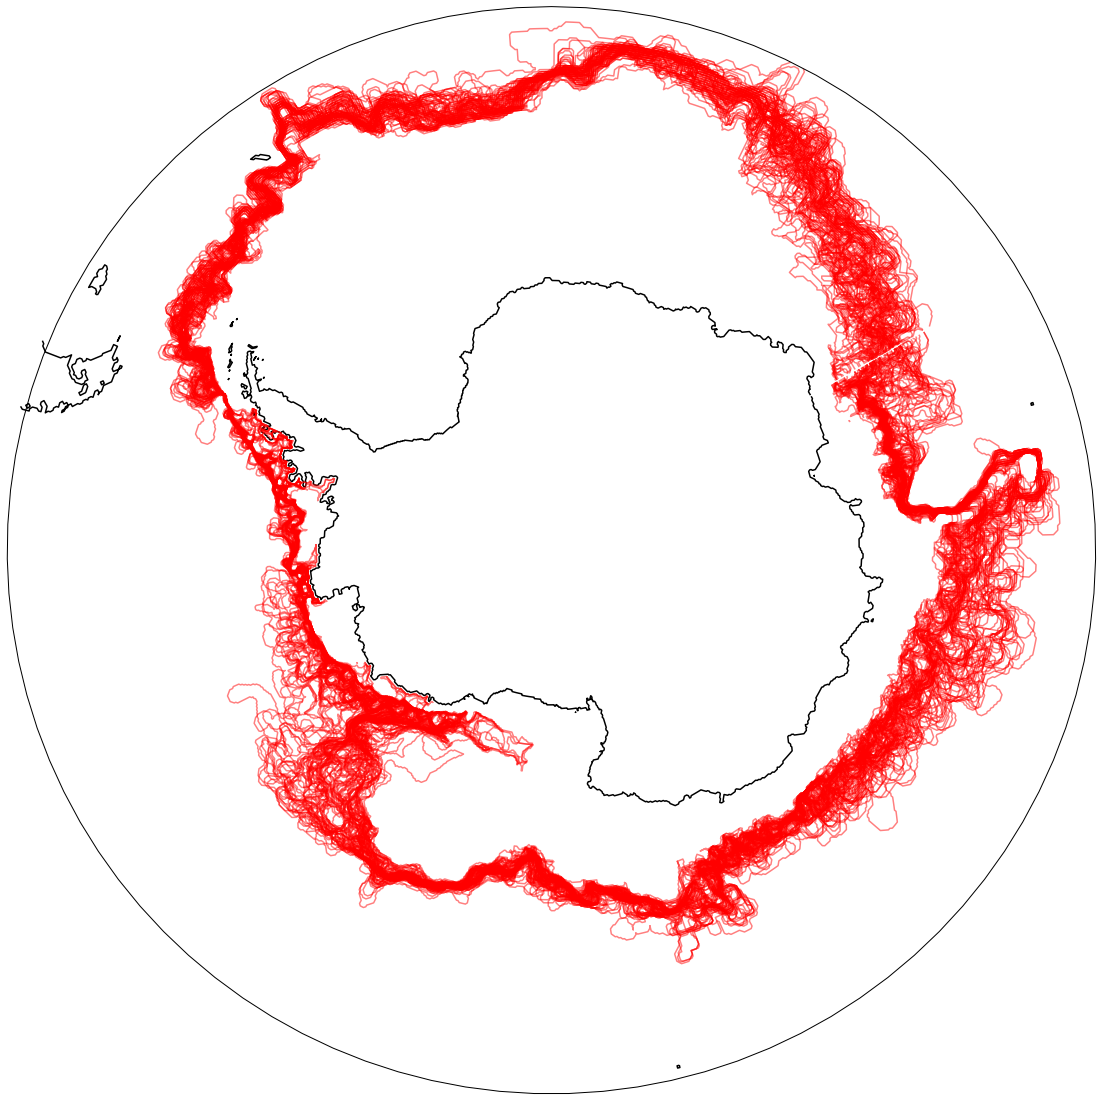

In [26]:
fig = plt.figure(figsize=[20, 20])
proj = ccrs.Stereographic(central_longitude=0,central_latitude=-90)
ax = plt.subplot(projection = proj)
lat_north = -50
so_basics(ax,land_mask_25,geolon_25, geolat_25, lat_north = lat_north, grid = False)

for i in range(100):
    ax.contour(p25_SUCpsig_mask_array.geolon, p25_SUCpsig_mask_array.geolat,p25_SUCpsig_mask_array.isel(time = i).fillna(0), levels = [0,1], colors = 'r',alpha = 0.5,transform = ccrs.PlateCarree())

plt.show()